# Libraries

In [617]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from itertools import chain

# Plotting Libs
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistical libs
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


# Load Dfs

In [618]:
df = pd.read_pickle(r".\df_data\df.pkl")
df0 = pd.read_pickle(r".\df_data\df0.pkl")
df1 = pd.read_pickle(r".\df_data\df1.pkl")
df2 = pd.read_pickle(r".\df_data\df2.pkl")
df3 = pd.read_pickle(r".\df_data\df3.pkl")
df4 = pd.read_pickle(r".\df_data\df4.pkl")
df5 = pd.read_pickle(r".\df_data\df5.pkl")

# Df Input

In [619]:
i = 5
dfi = df5

In [620]:
dfis = [df0, df1, df2, df3, df4, df5, df]

# Functions

## chi2_fun

In [621]:
def chi2_fun(col, dfi, i):
    global p_value
    p_value = []
    
    df_plot = dfi[[col, "Study_Status_Bin"]].copy()  
    df_plot = df_plot.dropna(subset = [col])
    df_plot = df_plot.reset_index(drop = True)
    print(f"df{i}-Phase{i}:")    

# Descriptives
    print(f"df{i}-Phase{i}: {col} vs Study Status")
    df_plot[col] = df_plot[col].astype('category')

    # display(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"])) # pivot in log_fun also
    df_plot[col] = df_plot[col].astype('category') 
    stat = stats.chi2_contingency(pd.crosstab(df_plot[col], df_plot["Study_Status_Bin"]))
    
    pvalue = stat.pvalue
    p_value.append(pvalue)
    print(f'df{i}-Phase{i}, {col} p-value:\n{pvalue}')

# Test
    if pvalue < 0.05 :
        print("P-value < 0.05\n")
    else:
        print("No significant difference\n")
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot 
# Plotted in log_fun 

    return p_value

## Logistic

In [622]:
def log_fun(col, dfi, i, type, t, rot, drop_col = None):
    global aic_categ
    global p_value
    global cl
    aic_categ = []
    p_value = []

    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    df_plot = dfi[['Study_Status_Bin', col]].copy()
    df_plot = df_plot.dropna(subset = [col]).reset_index(drop = True)  
    df_expl = df_plot.explode(col) # Do not reset index, needed for groupby
    df_expl[col] = pd.Categorical(df_expl[col], ordered = t)
    df_expl[col] = df_expl[col].cat.remove_unused_categories()

    # Pivot Table
    display(df_expl.pivot_table(index = ["Study_Status_Bin"], columns = [col], aggfunc = "size", fill_value = 0, observed = False))

    # Dummies - df_model      
    if type == 'list':    
        dummies = pd.get_dummies(df_expl[col] , drop_first = False, dtype = int , prefix = '' , prefix_sep = '', dummy_na = False)
        dummies.index = df_expl.index # ensure same index dummies - df_expl --> same index dummies.grouped - df_plot (= melted df_expl)
        dummies = dummies.groupby(dummies.index).sum()   # index needed for groupby comes from dummies not exploded df_plot
        df_model = pd.concat([df_plot.drop(columns = [col], axis = 1), dummies], axis=1)
        if drop_col != None:
            df_model = df_model.drop(columns = [drop_col], axis = 1)
    else:
        df_model = df_expl.copy()
        cats = sorted(dfi[col].dropna().unique())
        df_model[col] = df_model[col].map({cats[0]: 0, cats[1]: 1, 'No':0, 'Yes':1})
                
    # Model
    X = sm.add_constant(df_model.drop(columns = ["Study_Status_Bin"], axis = 1))
    y = (df_model["Study_Status_Bin"] == "COMPLETED").astype(int)

    model = sm.Logit(y, X)
    results = model.fit(method = 'lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_categ.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

    # df_plot
    df_plot = df_plot.explode(col).reset_index(drop = True)
    df_plot[col] = pd.Categorical(df_plot[col], ordered = t)
    df_plot[col] = df_plot[col].cat.remove_unused_categories()
    
    # Plot
    plt.figure(figsize = (10, 2))
    sns.countplot(data = df_plot, x = col, hue = 'Study_Status_Bin')
    plt.xticks(rotation = rot, fontsize = 8) 
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 2)
    plt.title(f"df{i}-Phase{i}: {col} vs Study Status")

    return aic_categ, p_value, cl

## Log_fun_cont

In [623]:
def log_fun_cont(col, dfi, i):
    global aic_cont
    global p_value
    global cl
    aic_cont = []
    p_value = []

    df_plot = dfi.dropna(subset = [col]).reset_index(drop = True) 
    df_plot_y = df_plot[["Study_Status_Bin"]].copy()
    df_plot_x = df_plot[[col]].copy()

# Dfi names
    print(f"df{i}-Phase{i}:\n{col} vs Study Status")
    print("\n")
    
# Descriptives
    print(df_plot[col].describe())
    print("\n")

# Scale
    scaler = StandardScaler()
    data_scaled_x = scaler.fit_transform(df_plot_x)
    df_scaled_x = pd.DataFrame(data_scaled_x)
    df_scaled = pd.concat([df_plot_y, df_scaled_x], axis=1)
    df_scaled.rename(columns={0: col}, inplace=True)

    X = sm.add_constant(df_scaled[col])
    y = (df_scaled["Study_Status_Bin"] == "COMPLETED").astype(int)

# Model
    model = sm.Logit(y, X)
    results = model.fit(method='lbfgs', maxiter = 500)
    print(results.summary())
    print("\n")

    # AIC
    aic = round(results.aic, 0)
    aic_cont.append(aic)
    pvalue = results.pvalues
    p_value.append(pvalue)
    cl = results.conf_int()
    
    print(f'df{i}-Phase{i}, {col} p-values:\n{p_value}\n')
    print(f'df{i}-Phase{i}, {col} AIC:\n{aic}')
    print("\n------------------------------------------------------------------------------------------------------------\n")

# Plot
    fig , ax = plt.subplots(figsize = (20, 4) , ncols = 2, nrows = 1, layout = 'tight')
    color = sns.color_palette("tab10", n_colors = 2)
    
    sns.boxplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[0] , legend = True) 
    # sns.barplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[0,1] , legend = False) 
    sns.kdeplot(x = col, hue = "Study_Status_Bin", data = dfi, ax = ax[1] , legend = False) 

    ax[0].legend(bbox_to_anchor = (1.05, 1), loc = 2)
    
    return aic_cont, p_value, cl

## Fun_Compare

In [624]:
def fun_compare(i, **args):

    AIC_Min = pd.DataFrame([args], index = [f'{list(args.keys())[0]}'])  
    AIC_Min['AIC_min'] = AIC_Min.idxmin(axis = 1)
    AIC_Min.index.name = f'df{i}'
    return AIC_Min

# Visualization

## Phases_List
All df before Seperation into Phases

df-Phase:
Phases_List vs Study Status


Phases_List,PHASE0,PHASE1,PHASE2,PHASE3,PHASE4,PHASE_NA
Study_Status_Bin,,,,,,
COMPLETED,1802,22439,21374,13417,10796,87699
TERMINATED,502,4736,7423,2890,2277,10132


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:               177586
Model:                          Logit   Df Residuals:                   177580
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.02803
Time:                        21:18:15   Log-Likelihood:                -71671.
converged:                       True   LL-Null:                       -73738.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6028      0.029     55.499      0.000       1.546       1.659
PHASE1         0.0818      0.028      2.889      0.004       0.026       0.137
PHASE2        -0.5631      0.027    -21.214      0.0

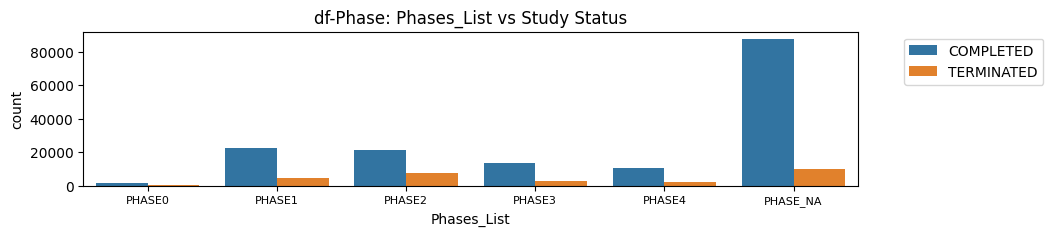

In [625]:
Phases_List = log_fun('Phases_List', df, '', 'list', False, 0, 'PHASE0')

## Adverse


### Adverse_List

df5-Phase5:
Adverse_List vs Study Status


Adverse_List,Adv_Death,Adv_None,Adv_Serious,Adv_Unspecified
Study_Status_Bin,,,,
COMPLETED,4206,80348,2986,4675
TERMINATED,470,9315,352,522


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97827
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               3.254e-05
Time:                        21:18:16   Log-Likelihood:                -32562.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.5480
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1559      0.011    198.152      0.000       2.135       2.177
Adv_Death           0.0440      0.057      0.776      0.438      -0.067       0.155
Adv_Serious        -0.0859      

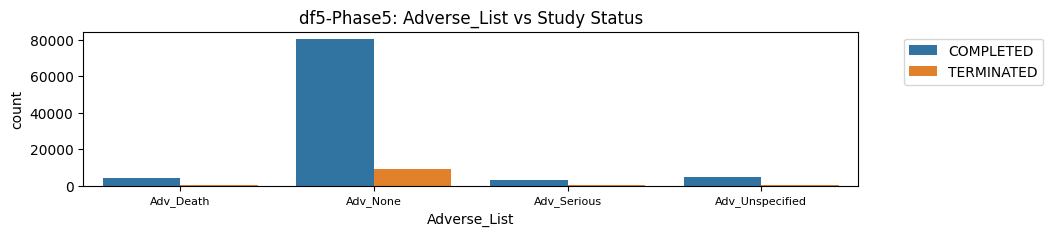

In [626]:
Adverse_List = log_fun("Adverse_List", dfi, i, 'list', False, 0, 'Adv_None')
# Adverse Death has p value >> 0.05 and laso coef ~ 0.0 --> Death does not support adverse from the drug/intervention.
# Corresponds to event noticed in trial but may have to do with patience state of health

### Adverse_Counts
Many unique points, in most of features values, are out of main distribution. --> Make pd.cut
log_fun('Adverse_Counts', dfi, i, 'bin', True, 0) --> Error for small values in some levels


df5-Phase5:
Adverse_Counts vs Study Status


count    97831.000000
mean         5.300631
std        158.296170
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      28085.000000
Name: Adverse_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               7.656e-05
Time:                        21:18:16   Log-Likelihood:                -32560.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                   0.02555
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

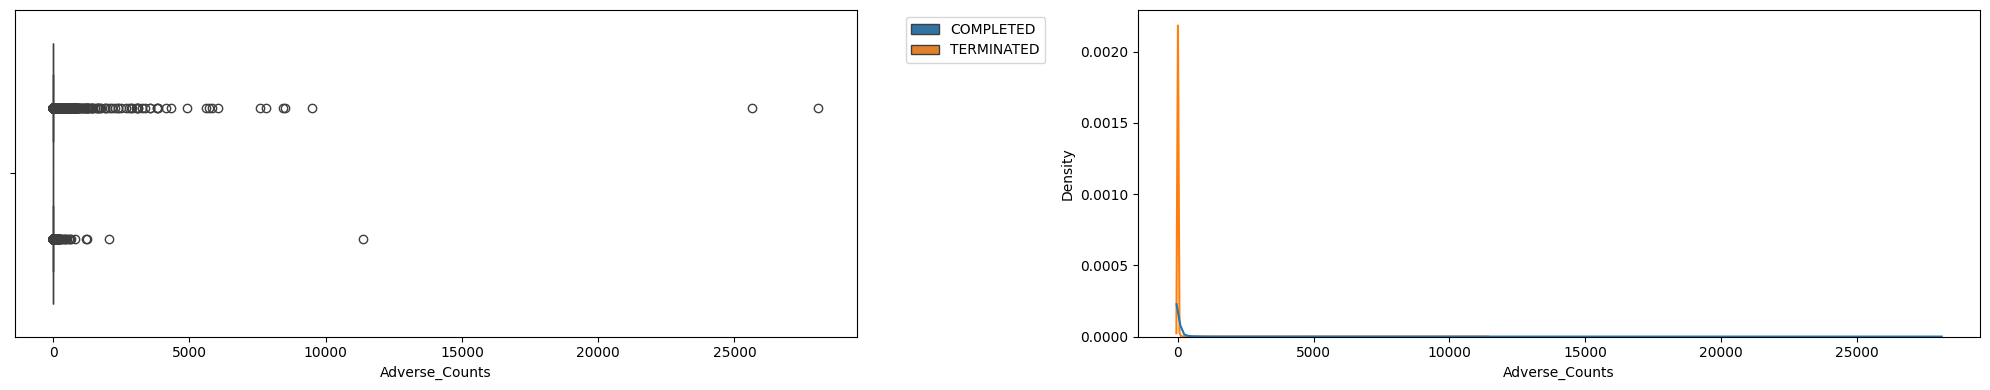

In [627]:
Adverse_Counts = log_fun_cont("Adverse_Counts", dfi, i)  

### Adverse_Counts_Log

df5-Phase5:
Adverse_Counts_Log vs Study Status


count    97831.000000
mean         0.173619
std          0.761104
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.243027
Name: Adverse_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0005278
Time:                        21:18:17   Log-Likelihood:                -32546.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 4.550e-09
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------

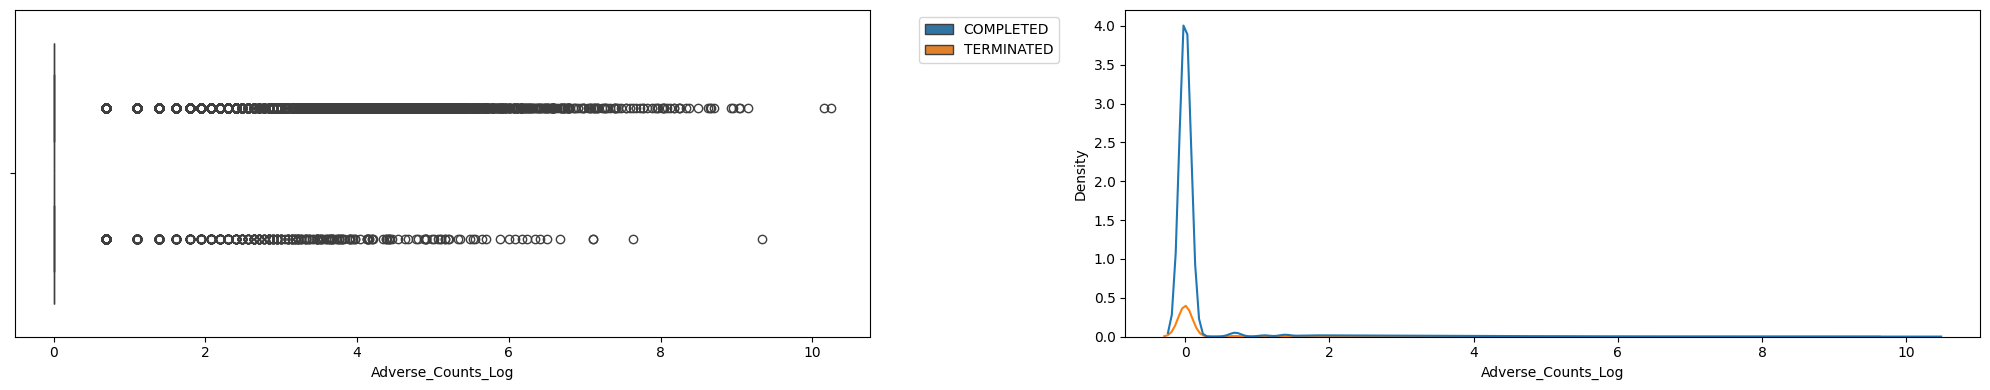

In [628]:
Adverse_Counts_Log = log_fun_cont("Adverse_Counts_Log", dfi, i)

### Adverse_Counts_Sqrt

df5-Phase5:
Adverse_Counts_Sqrt vs Study Status


count    97831.000000
mean         0.342184
std          2.276751
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        167.585799
Name: Adverse_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0005225
Time:                        21:18:19   Log-Likelihood:                -32546.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 5.430e-09
                          coef    std err          z      P>|z|      [0.025      0.975]
----------

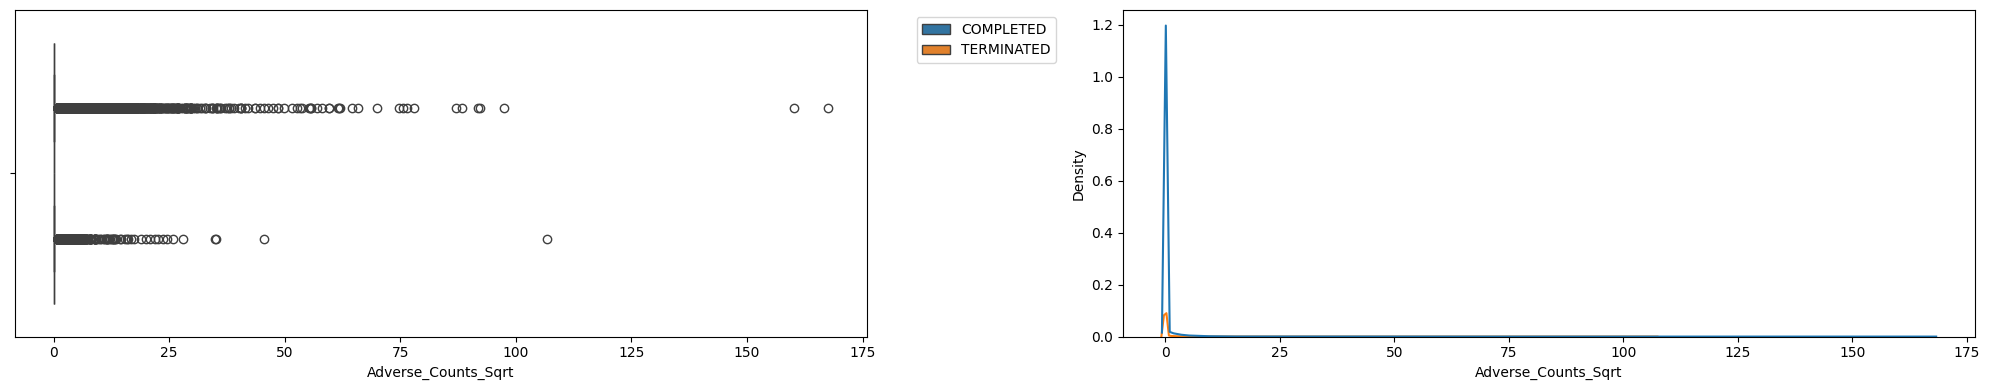

In [629]:
Adverse_Counts_Sqrt = log_fun_cont("Adverse_Counts_Sqrt", dfi, i)

### Adverse_Bin

df5-Phase5:
df5-Phase5: Adverse_Bin vs Study Status
df5-Phase5, Adverse_Bin p-value:
0.34949736365258033
No significant difference


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Adverse_Bin vs Study Status


Adverse_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,81748,5951
TERMINATED,9470,662


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               1.418e-05
Time:                        21:18:20   Log-Likelihood:                -32563.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.3366
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1556      0.011    198.575      0.000       2.134       2.177
Adverse_Bin     0.0403      0.042      0.951      0.342      -0.043       0.123


df5-Phase5, Adverse_Bin p-values:
[const      

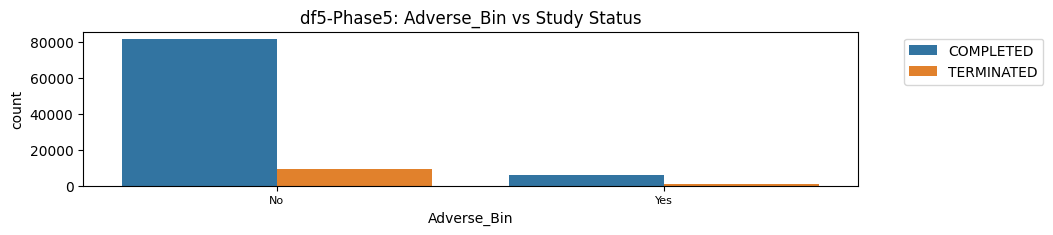

In [630]:
chi2_fun('Adverse_Bin', dfi, i)
#### log_fun
Adverse_Bin = log_fun("Adverse_Bin", dfi, i, 'bin', False, 0)

In [631]:
#### AIC 
# --> wont be used --> only one of Adverse_Counts or Adverse_Detail_Counts will be used
# Does not include Adverse_Categ as distribution was until 0.75 quantile almost to all dfis = 0. 
'''Adverse_Counts_aic = fun_compare(i, Adverse_Counts = Adverse_Counts[0], 
                                 Adverse_Counts_Log = Adverse_Counts_Log[0], 
                                 Adverse_Counts_Sqrt = Adverse_Counts_Sqrt[0],
                                 Adverse_Categ = Adverse_Categ[0],
                                 Adverse_Bin = Adverse_Bin[0])'''

'Adverse_Counts_aic = fun_compare(i, Adverse_Counts = Adverse_Counts[0], \n                                 Adverse_Counts_Log = Adverse_Counts_Log[0], \n                                 Adverse_Counts_Sqrt = Adverse_Counts_Sqrt[0],\n                                 Adverse_Categ = Adverse_Categ[0],\n                                 Adverse_Bin = Adverse_Bin[0])'

### Adverse_Detail_List


df5-Phase5:
Adverse_Detail_List vs Study Status


Adverse_Detail_List,Adv_Det_Blood/ Lymphatic,Adv_Det_Cardio,Adv_Det_Death,Adv_Det_Ear,Adv_Det_Endocrine,Adv_Det_Eye,Adv_Det_Gastrointestinal,Adv_Det_General,Adv_Det_Genetic,Adv_Det_Hepatobiliary,...,Adv_Det_Pregnancy/ Perinatal,Adv_Det_Product Issues,Adv_Det_Psychiatric/ Social,Adv_Det_Renal/ Urinary,Adv_Det_Reproductive/ Breast,Adv_Det_Respiratory,Adv_Det_Skin,Adv_Det_Social,Adv_Det_Surgical/ Medical,Adv_Det_Vascular
Study_Status_Bin,,,,,,,,,,,,,,,,,,,,,
COMPLETED,856,1551,1861,405,439,679,2061,2221,98,446,...,163,271,1074,1092,503,1623,1569,202,840,1050
TERMINATED,111,201,194,43,32,66,236,262,9,45,...,2,37,99,144,60,202,176,6,78,134


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97802
Method:                           MLE   Df Model:                           28
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001437
Time:                        21:18:21   Log-Likelihood:                -32516.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 5.417e-09
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     2.1553      0.011    199.434      0.000       2.134       2.176
Adv_Det_Blood/ Lymphatic                 -0.1192  

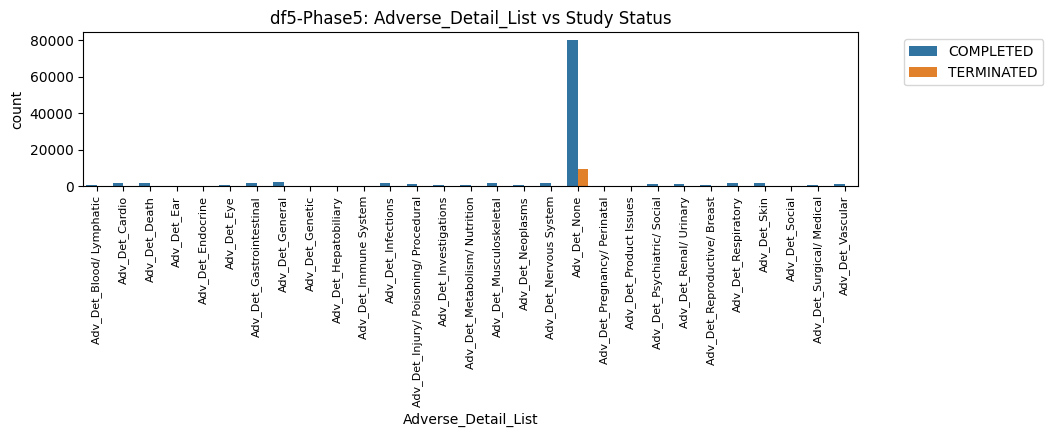

In [632]:
Adverse_Detail_List = log_fun("Adverse_Detail_List", dfi, i, 'list', False, 90, 'Adv_Det_None')

### Adverse_Detail_Counts
- Different from Adverse_Counts: 
Adverse_Counts = Count of events category (e.g 100 serioues)
Adverse_Detail_Counts = How many organs.


df5-Phase5:
Adverse_Detail_Counts vs Study Status


count    97831.000000
mean         0.314082
std          1.696128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.000000
Name: Adverse_Detail_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               6.941e-07
Time:                        21:18:22   Log-Likelihood:                -32563.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.8316
                            coef    std err          z      P>|z|      [0.025      0.975]
----

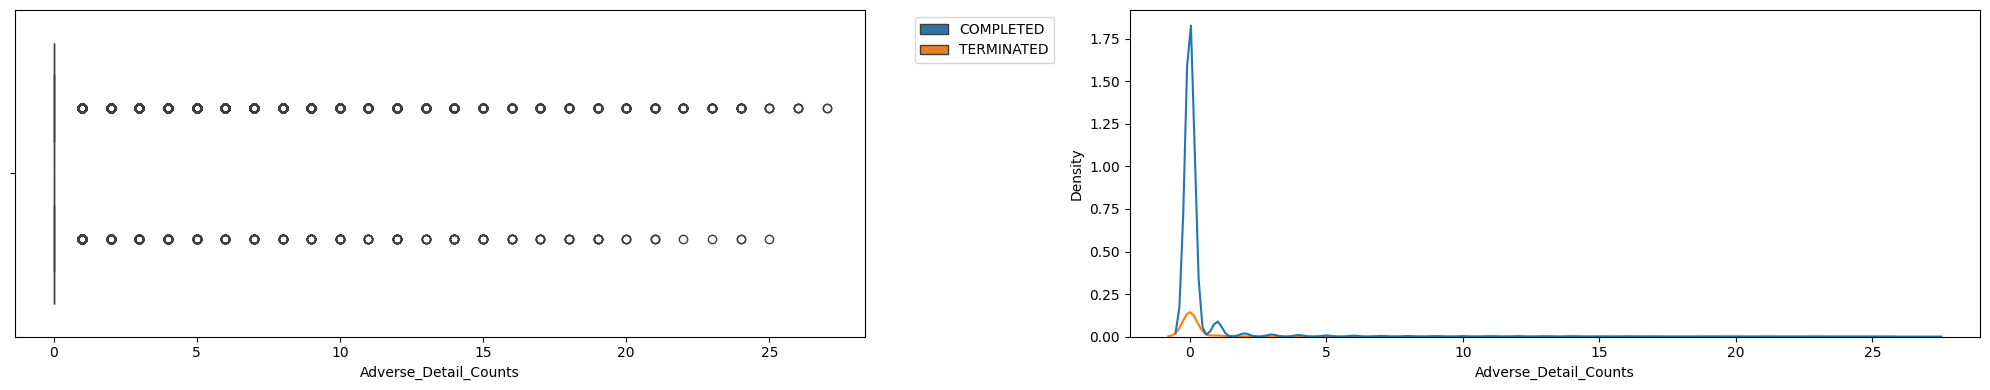

In [633]:
Adverse_Detail_Counts = log_fun_cont("Adverse_Detail_Counts", dfi, i)

### Adverse_Detail_Counts_Log


df5-Phase5:
Adverse_Detail_Counts_Log vs Study Status


count    97831.000000
mean         0.104511
std          0.402745
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.332205
Name: Adverse_Detail_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               1.847e-06
Time:                        21:18:23   Log-Likelihood:                -32563.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.7287
                                coef    std err          z      P>|z|      [0.025     

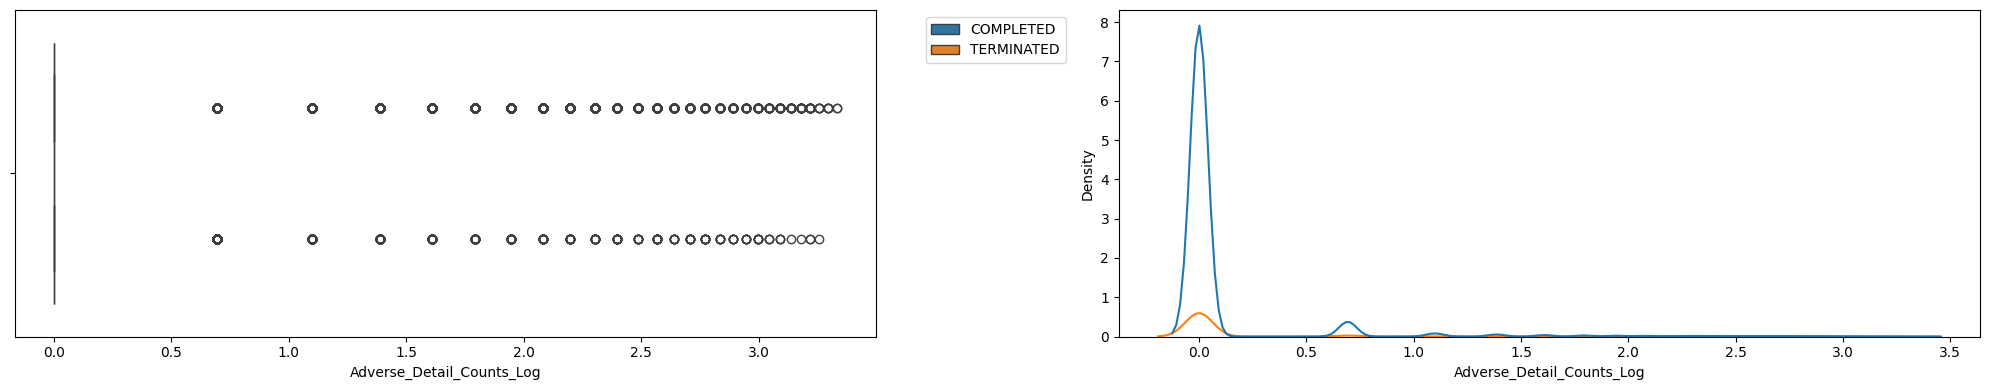

In [634]:
Adverse_Detail_Counts_Log = log_fun_cont("Adverse_Detail_Counts_Log", dfi, i)

### Adverse_Detail_Counts_Sqrt


df5-Phase5:
Adverse_Detail_Counts_Sqrt vs Study Status


count    97831.000000
mean         0.141047
std          0.542394
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.196152
Name: Adverse_Detail_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               2.964e-06
Time:                        21:18:24   Log-Likelihood:                -32563.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.6604
                                 coef    std err          z      P>|z|      [0.025  

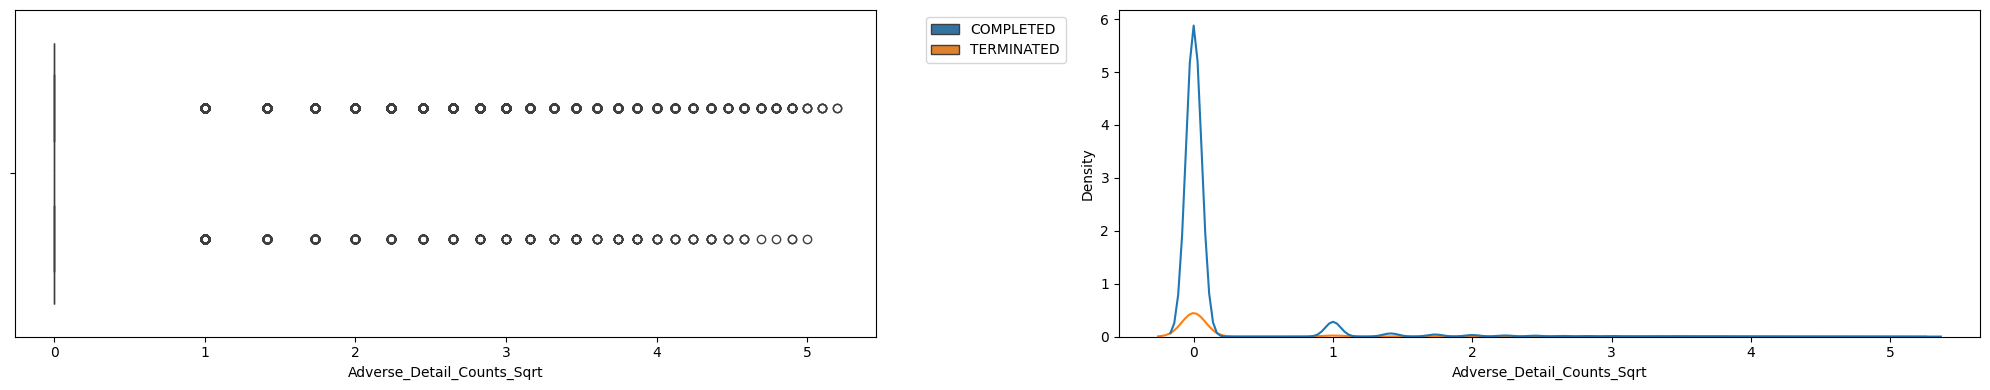

In [635]:
Adverse_Detail_Counts_Sqrt = log_fun_cont("Adverse_Detail_Counts_Sqrt", dfi, i)

#### AIC

In [636]:
Adverse_Counts_aic_all = fun_compare(i, Adverse_Detail_Counts = Adverse_Detail_Counts[0], 
                                        Adverse_Detail_Counts_Log = Adverse_Detail_Counts_Log[0],
                                        Adverse_Detail_Counts_Sqrt = Adverse_Detail_Counts_Sqrt[0],
                                        Adverse_Counts = Adverse_Counts[0], 
                                        Adverse_Counts_Log = Adverse_Counts_Log[0], 
                                        Adverse_Counts_Sqrt = Adverse_Counts_Sqrt[0],
                                        # Adverse_Bin = Adverse_Bin[0] --> will be kept as it is
                                        )

#### AIC_all

In [637]:
Adverse_aic_all = fun_compare(i, Adverse_List = Adverse_List[0], Adverse_Detail_List = Adverse_Detail_List[0])

## Placebo_Bin

df5-Phase5:
df5-Phase5: Placebo_Bin vs Study Status
df5-Phase5, Placebo_Bin p-value:
1.1273527639325284e-08
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Placebo_Bin vs Study Status


Placebo_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,78272,9427
TERMINATED,9230,902


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0005261
Time:                        21:18:25   Log-Likelihood:                -32546.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 4.821e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1377      0.011    194.244      0.000       2.116       2.159
Placebo_Bin     0.2090      0.037      5.717      0.000       0.137       0.281


df5-Phase5, Placebo_Bin p-values:
[const      

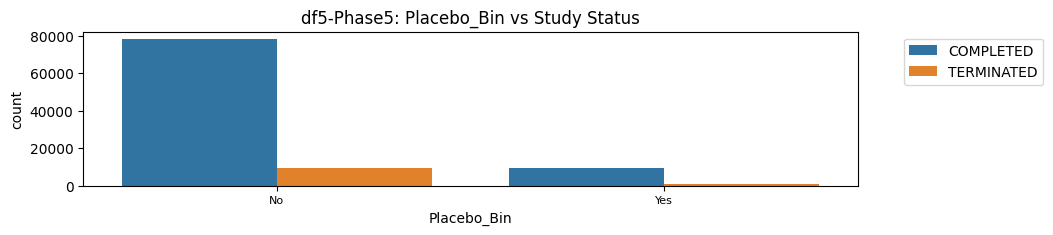

In [638]:
chi2_fun("Placebo_Bin", dfi, i)
### log_fun
Placebo_Bin = log_fun('Placebo_Bin', dfi, i, 'bin', False, 0)

## Standard_Care_Bin 

df5-Phase5:
df5-Phase5: Standard_Care_Bin vs Study Status
df5-Phase5, Standard_Care_Bin p-value:
1.4136217480093348e-25
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Standard_Care_Bin vs Study Status


Standard_Care_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,81170,6529
TERMINATED,9080,1052


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001552
Time:                        21:18:26   Log-Likelihood:                -32512.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 8.855e-24
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1905      0.011    197.950      0.000       2.169       2.212
Standard_Care_Bin    -0.3649      0.035    -10.421      0.000      -0.434      -0.296


df5-Phase5, Standard_C

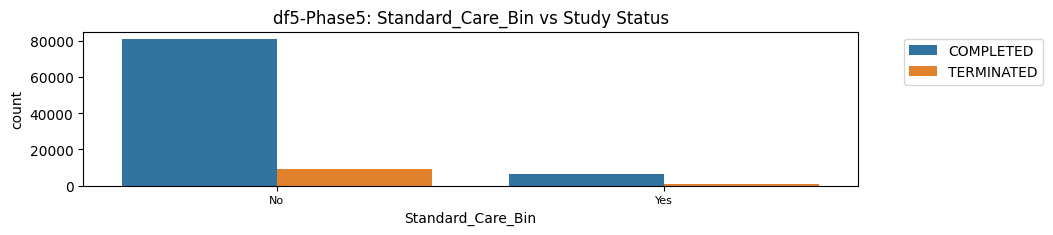

In [639]:
chi2_fun("Standard_Care_Bin", dfi, i)
### log_fun
Standard_Care_Bin = log_fun('Standard_Care_Bin', dfi, i, 'bin', False, 0)

## Healthy_Bin

df5-Phase5:
df5-Phase5: Healthy_Bin vs Study Status
df5-Phase5, Healthy_Bin p-value:
1.944386194873863e-195
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Healthy_Bin vs Study Status


Healthy_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,52949,34712
TERMINATED,7659,2472


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97792
Model:                          Logit   Df Residuals:                    97790
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.01447
Time:                        21:18:27   Log-Likelihood:                -32085.
converged:                       True   LL-Null:                       -32557.
Covariance Type:            nonrobust   LLR p-value:                6.636e-207
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9335      0.012    158.155      0.000       1.910       1.957
Healthy_Bin     0.7086      0.024     29.353      0.000       0.661       0.756


df5-Phase5, Healthy_Bin p-values:
[const      

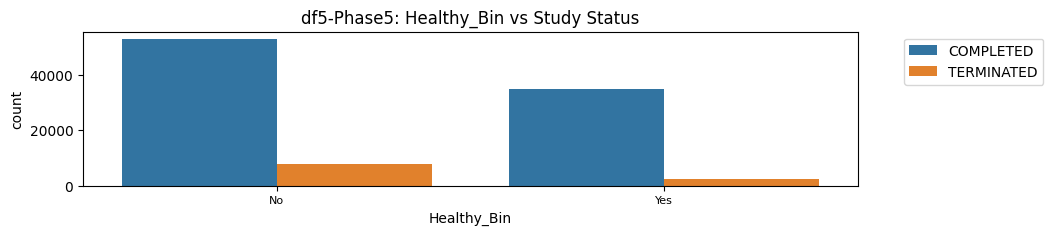

In [640]:
chi2_fun("Healthy_Bin", dfi, i)
### log_fun
Healthy_Bin = log_fun('Healthy_Bin', dfi, i, 'bin', False, 0)

## Covid_19_Bin

df5-Phase5:
df5-Phase5: Covid_19_Bin vs Study Status
df5-Phase5, Covid_19_Bin p-value:
0.03762084161599872
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Covid_19_Bin vs Study Status


Covid_19_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,86776,923
TERMINATED,10002,130


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               6.609e-05
Time:                        21:18:27   Log-Likelihood:                -32561.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                   0.03802
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.1606      0.011    204.607      0.000       2.140       2.181
Covid_19_Bin    -0.2021      0.094     -2.145      0.032      -0.387      -0.017


df5-Phase5, Covid_19_Bin p-values:
[const 

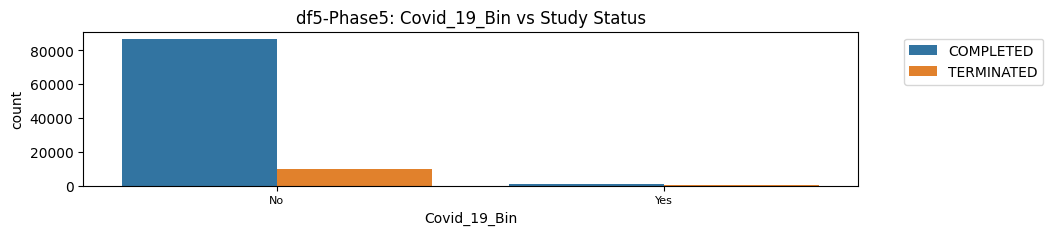

In [641]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'bin', False, 0)

## Conditions

### Conditions_List
- Conditions_List col. has almost all data points to Disease category. (see df['Conditions_List'] value counts), while Conditions_Detail_List gives same information with more categories and evenly sparsed data.


df5-Phase5:
Conditions_List vs Study Status


Conditions_List,Cond_Diseases,Cond_Health Care,Cond_Other,"Cond_Phenomena, Processes","Cond_Psychiatry, Psychology, Anthropology, Sociology","Cond_Therapeutic, Diagnostic, Equipment"
Study_Status_Bin,,,,,,
COMPLETED,71630,417,9152,10178,19152,3436
TERMINATED,8881,39,669,1009,1844,294


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97825
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.004972
Time:                        21:18:28   Log-Likelihood:                -32401.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 7.485e-68
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    2.5057      0.032     78.392      0.000       2.443       2.568
Cond_

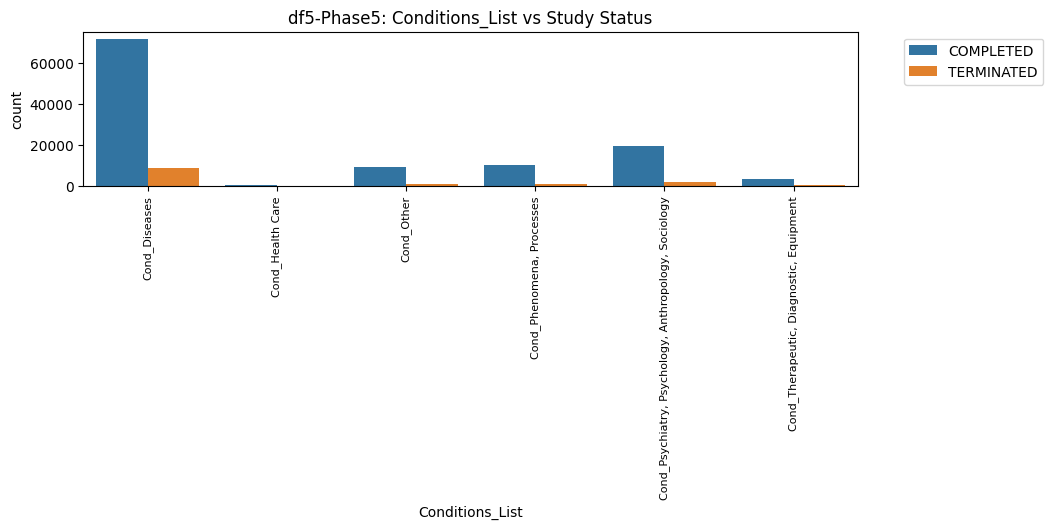

In [642]:
Conditions_List = log_fun("Conditions_List", dfi, i, 'list', False, 90, 'Cond_Other')

### Conditions_Detail_List

df5-Phase5:
Conditions_Detail_List vs Study Status


Conditions_Detail_List,Bacterial Infections and Mycoses,Cardiovascular,Chemical Disorders,Cond_Detail_Other,"Digestive System, Nutritional, Metabolic",Endocrine System,Eye,Health Care,"Hemic, Lymphatic, Immune System","Hereditary, Neonatal, Abnormalities",...,Otorhinolaryngologic,"Pathological Conditions, Signs, Symptoms","Psychiatry, Psychology, Anthropology, Sociology","Respiratory, Circulatory","Skin, Tissue",Stomatognathic,"Therapeutics, Diagnosis, Equipment","Urogenital, Pregnancy",Virus Diseases,"Wounds, Injuries"
Study_Status_Bin,,,,,,,,,,,,,,,,,,,,,
COMPLETED,4402,9442,2129,9152,13542,4253,2275,417,4468,2594,...,1300,3999,21023,6125,6511,3238,3720,7036,2372,4374
TERMINATED,576,1526,202,669,1597,489,294,39,554,393,...,240,349,1987,903,918,199,303,990,251,731


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97808
Method:                           MLE   Df Model:                           22
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.01500
Time:                        21:18:29   Log-Likelihood:                -32074.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                1.512e-192
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               2.3816      0.022    107.771      0.000       2.338       2.425
Bacterial Infections

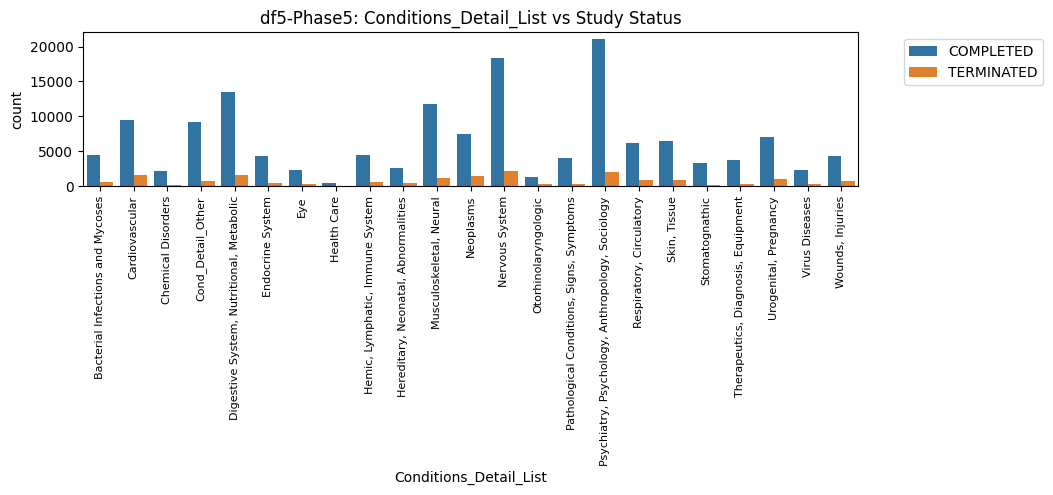

In [643]:
Conditions_Detail_List = log_fun("Conditions_Detail_List", dfi, i, 'list', False, 90, 'Cond_Detail_Other' )

#### AIC 
- Conditions_List and Conditions_Detail_List give similar information. 
- Conditions_List excluded. 
- Conditions_Detail_list is mmore spesific level of Condition_List column and thus, will just slowen the algorythms later
- Conditions_List col. has almost all data points to Disease category. (see df['Conditions_List'] value counts), while Conditions_Detail_List gives same information with more categories and evenly sparsed data.
- However more categories in Cond_Detail col --> lasso in Models file will exclude unessecary ones

#### AIC_all

In [644]:
Conditions_aic_all = fun_compare(i, Conditions_List = Conditions_List[0], 
                             Conditions_Detail_List = Conditions_Detail_List[0])

### Covid_19_Bin

df5-Phase5:
df5-Phase5: Covid_19_Bin vs Study Status
df5-Phase5, Covid_19_Bin p-value:
0.03762084161599872
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Covid_19_Bin vs Study Status


Covid_19_Bin,No,Yes
Study_Status_Bin,,
COMPLETED,86776,923
TERMINATED,10002,130


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               6.609e-05
Time:                        21:18:30   Log-Likelihood:                -32561.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                   0.03802
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.1606      0.011    204.607      0.000       2.140       2.181
Covid_19_Bin    -0.2021      0.094     -2.145      0.032      -0.387      -0.017


df5-Phase5, Covid_19_Bin p-values:
[const 

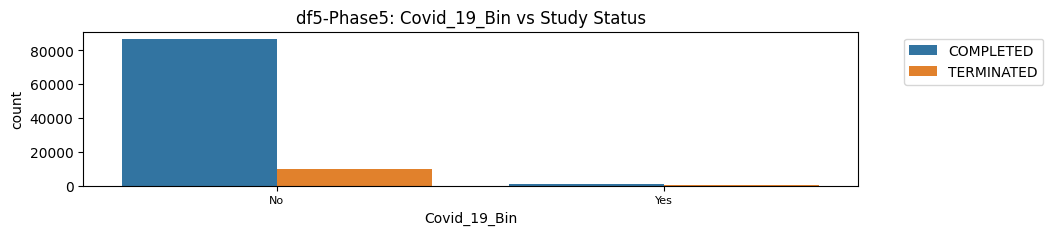

In [645]:
chi2_fun("Covid_19_Bin", dfi, i)
### log_fun
Covid_19_Bin = log_fun('Covid_19_Bin', dfi, i, 'Bin', False, 0)

## Funder_Type_List

df5-Phase5:
Funder_Type_List vs Study Status


Funder_Type_List,EDU_UNIV,FUNDER_OTHER,GOVERM,HEALTH,INDUSTRY
Study_Status_Bin,,,,,
COMPLETED,41513,11253,9784,16323,8826
TERMINATED,3849,1552,803,2514,1414


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97826
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.009304
Time:                        21:18:31   Log-Likelihood:                -32260.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                8.046e-130
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9811      0.027     73.164      0.000       1.928       2.034
EDU_UNIV       0.3972      0.032     12.454      0.000       0.335       0.460
GOVERM         0.5191      0.046     11.379      0.0

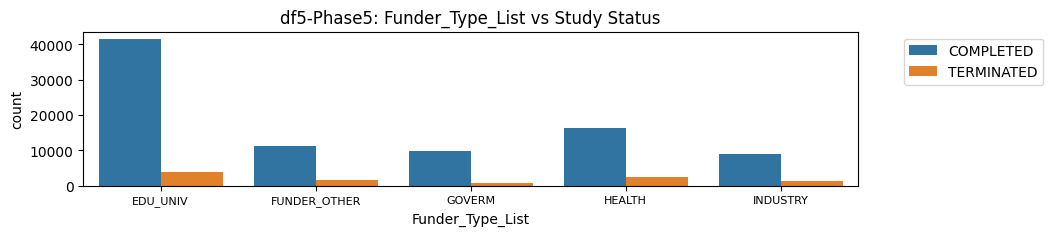

In [646]:
Funder_Type_List = log_fun("Funder_Type_List", dfi, i, 'list', False, 0, 'FUNDER_OTHER')

## Age_List

df5-Phase5:
Age_List vs Study Status


Age_List,ADULT,CHILD,OLDER_ADULT
Study_Status_Bin,,,
COMPLETED,78654,16829,60798
TERMINATED,9319,1608,8126


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97828
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.008506
Time:                        21:18:31   Log-Likelihood:                -32286.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                5.162e-121
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.5683      0.038     68.013      0.000       2.494       2.642
ADULT           0.0380      0.041      0.927      0.354      -0.042       0.118
OLDER_ADULT    -0.5927      0.028    -21.339    

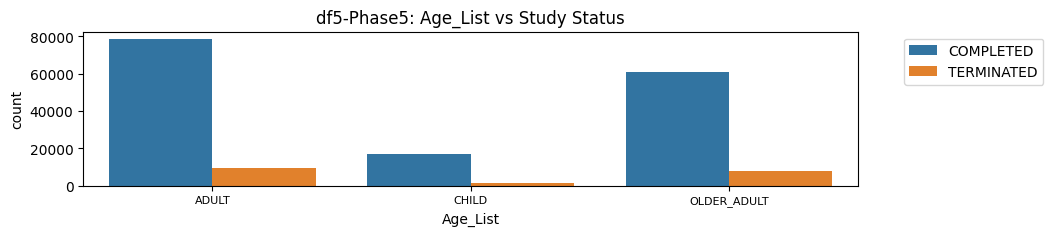

In [647]:
Age_List = log_fun("Age_List", dfi, i, 'list', False, 0, 'CHILD')

## Sex_List


df5-Phase5:
Sex_List vs Study Status


Sex_List,ALL,FEMALE,MALE
Study_Status_Bin,,,
COMPLETED,73942,10069,3637
TERMINATED,8798,1018,311


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97775
Model:                          Logit   Df Residuals:                    97772
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0008001
Time:                        21:18:32   Log-Likelihood:                -32520.
converged:                       True   LL-Null:                       -32546.
Covariance Type:            nonrobust   LLR p-value:                 4.912e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1287      0.011    188.758      0.000       2.107       2.151
FEMALE         0.1628      0.035      4.684      0.000       0.095       0.231
MALE           0.3304      0.060      5.494      0.0

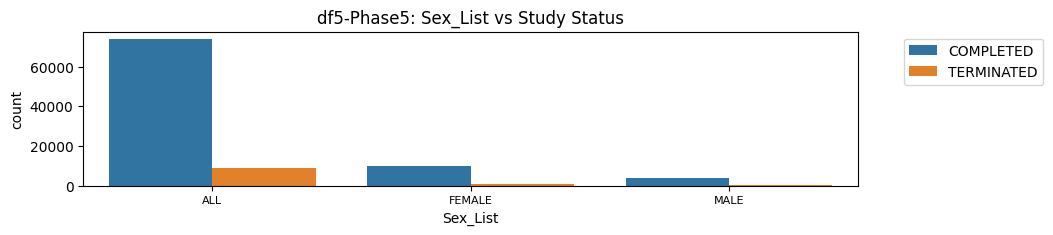

In [648]:
Sex_List = log_fun("Sex_List", dfi, i, 'list', False, 0, 'ALL')

## Study Design

### Allocation_List

df5-Phase5:
Allocation_List vs Study Status


Allocation_List,NA_RANDOMIZED,NON_RANDOMIZED,RANDOMIZED
Study_Status_Bin,,,
COMPLETED,18017,7053,62511
TERMINATED,2986,901,6235


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97703
Model:                          Logit   Df Residuals:                    97700
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.006781
Time:                        21:18:33   Log-Likelihood:                -32307.
converged:                       True   LL-Null:                       -32527.
Covariance Type:            nonrobust   LLR p-value:                 1.601e-96
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.7974      0.020     90.968      0.000       1.759       1.836
NON_RANDOMIZED     0.2602      0.041      6.422      0.000       0.181       0.340
RANDOMIZED         0.5077      0.024

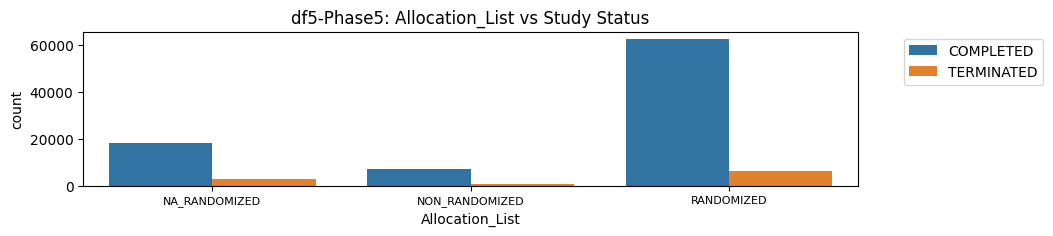

In [649]:
Allocation_List = log_fun("Allocation_List", dfi, i, 'list', False, 0, 'NA_RANDOMIZED')

### Masking_List


df5-Phase5:
Masking_List vs Study Status


Masking_List,DOUBLE,MASK_NONE,QUADRUPLE,SINGLE,TRIPLE
Study_Status_Bin,,,,,
COMPLETED,11870,45173,3707,21451,5352
TERMINATED,973,6548,407,1681,509


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97671
Model:                          Logit   Df Residuals:                    97666
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.01041
Time:                        21:18:33   Log-Likelihood:                -32177.
converged:                       True   LL-Null:                       -32515.
Covariance Type:            nonrobust   LLR p-value:                3.097e-145
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9314      0.013    146.057      0.000       1.905       1.957
DOUBLE         0.5702      0.036     15.895      0.000       0.500       0.641
QUADRUPLE      0.2779      0.054      5.159      0.0

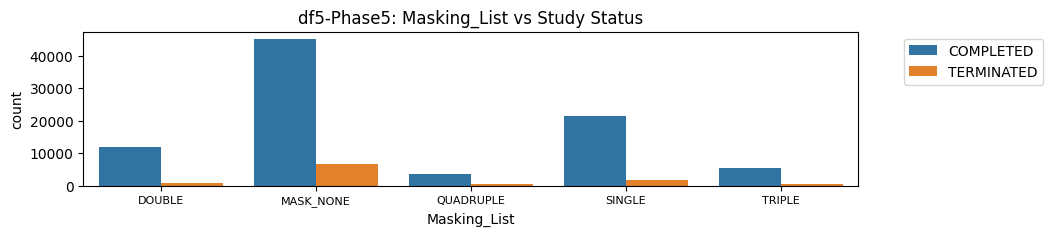

In [650]:
Masking_List = log_fun("Masking_List", dfi, i, 'list', False, 0, 'MASK_NONE')

### Masking_Detail_List

df5-Phase5:
Masking_Detail_List vs Study Status


Masking_Detail_List,CARE_PROVIDER,INVESTIGATOR,MASK_DET_NONE,OUTCOMES_ASSESSOR,PARTICIPANT
Study_Status_Bin,,,,,
COMPLETED,8191,16900,45173,24141,26824
TERMINATED,915,1535,6548,2006,2317


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97652
Model:                          Logit   Df Residuals:                    97647
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.008300
Time:                        21:18:34   Log-Likelihood:                -32228.
converged:                       True   LL-Null:                       -32498.
Covariance Type:            nonrobust   LLR p-value:                1.944e-115
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9874      0.013    155.236      0.000       1.962       2.013
CARE_PROVIDER        -0.3979      0.042     -9.406      0.000      -0.481      -0.315
INVESTIGATOR          0.

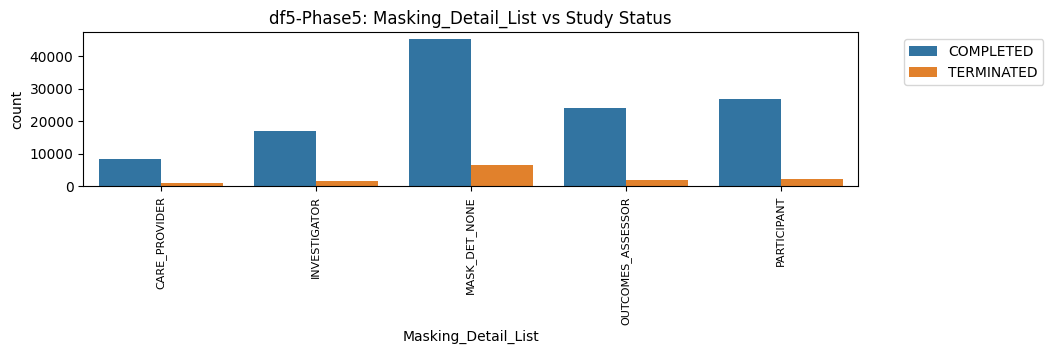

In [651]:
Masking_Detail_List = log_fun("Masking_Detail_List", dfi, i, 'list', False, 90, 'MASK_DET_NONE')


#### AIC_all

In [652]:
Masking_aic_all = fun_compare(i, Masking_List = Masking_List[0], 
                             Masking_Detail_List = Masking_Detail_List[0])

### Primary_Purpose_List


df5-Phase5:
Primary_Purpose_List vs Study Status


Primary_Purpose_List,BASIC_SCIENCE,DEVICE_FEASIBILITY,DIAGNOSTIC,HEALTH_SERVICES_RESEARCH,PREVENTION,PRIM_PURP_OTHER,SCREENING,SUPPORTIVE_CARE,TREATMENT
Study_Status_Bin,,,,,,,,,
COMPLETED,6140,605,5201,4660,11828,8738,1420,8878,39043
TERMINATED,531,129,925,337,985,921,142,961,5088


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                96532
Model:                          Logit   Df Residuals:                    96523
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.007372
Time:                        21:18:35   Log-Likelihood:                -31940.
converged:                       True   LL-Null:                       -32177.
Covariance Type:            nonrobust   LLR p-value:                 2.130e-97
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.2488      0.035     64.942      0.000       2.181       2.317
BASIC_SCIENCE                0.1983      0.057      3.481      0.000       0.087       0.

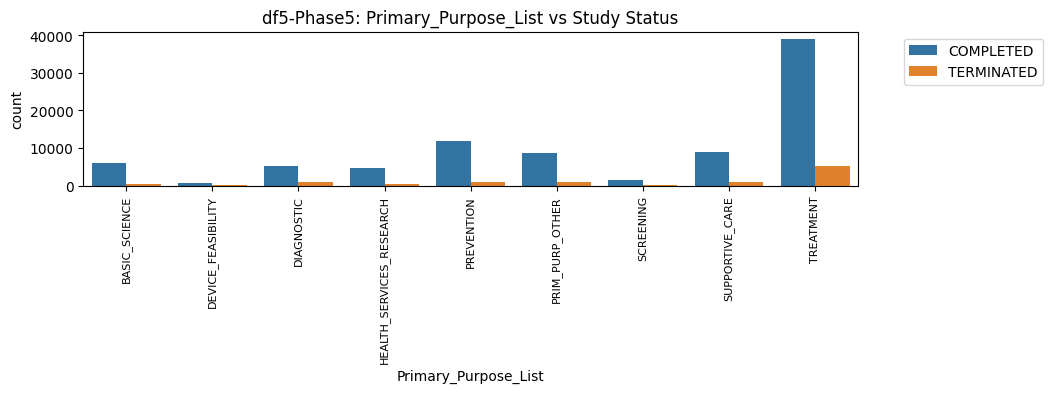

In [653]:
Primary_Purpose_List = log_fun("Primary_Purpose_List", dfi, i, 'list', False, 90, 'PRIM_PURP_OTHER')

## Arms

### Arm_Counts

df5-Phase5:
Arm_Counts vs Study Status


count    97286.000000
mean         2.064860
std          1.063453
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         32.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97286
Model:                          Logit   Df Residuals:                    97284
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.005544
Time:                        21:18:35   Log-Likelihood:                -32141.
converged:                       True   LL-Null:                       -32320.
Covariance Type:            nonrobust   LLR p-value:                 6.385e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

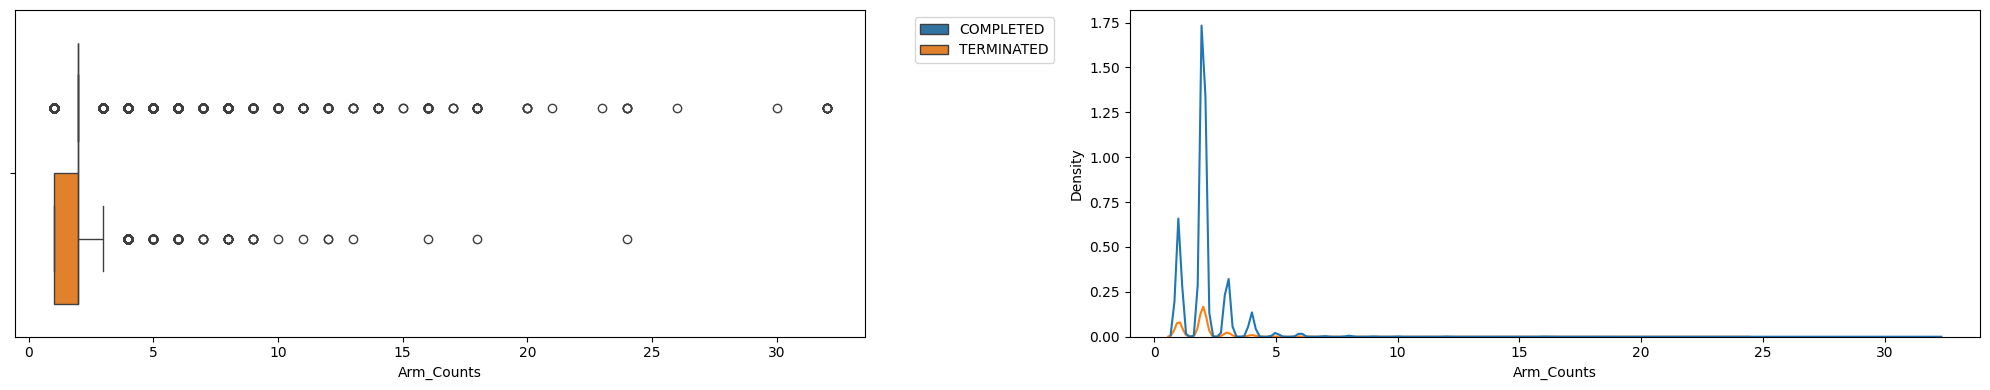

In [654]:
Arm_Counts = Arm_Counts = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Log

df5-Phase5:
Arm_Counts vs Study Status


count    97286.000000
mean         2.064860
std          1.063453
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         32.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97286
Model:                          Logit   Df Residuals:                    97284
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.005544
Time:                        21:18:37   Log-Likelihood:                -32141.
converged:                       True   LL-Null:                       -32320.
Covariance Type:            nonrobust   LLR p-value:                 6.385e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

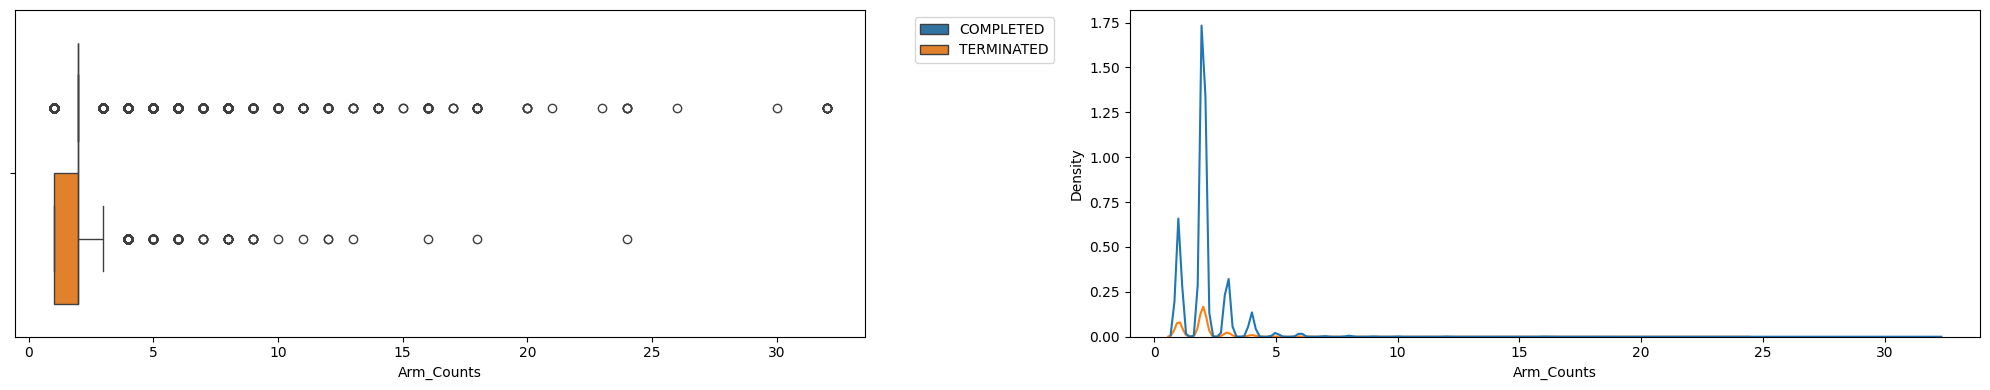

In [655]:
Arm_Counts_Log = Arm_Counts_Log = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Counts_Sqrt

df5-Phase5:
Arm_Counts vs Study Status


count    97286.000000
mean         2.064860
std          1.063453
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         32.000000
Name: Arm_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97286
Model:                          Logit   Df Residuals:                    97284
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.005544
Time:                        21:18:38   Log-Likelihood:                -32141.
converged:                       True   LL-Null:                       -32320.
Covariance Type:            nonrobust   LLR p-value:                 6.385e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

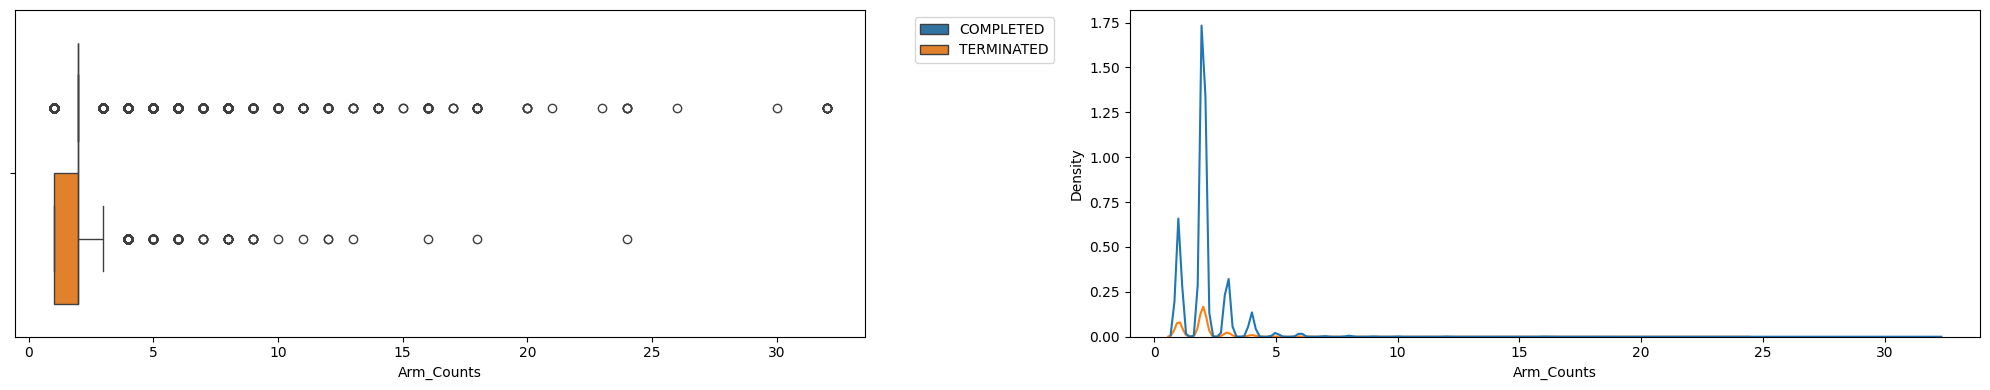

In [656]:
Arm_Counts_Sqrt = Arm_Counts_Sqrt = log_fun_cont("Arm_Counts", dfi, i)

### Arm_Categ

df5-Phase5:
df5-Phase5: Arm_Categ vs Study Status
df5-Phase5, Arm_Categ p-value:
2.1369022888583904e-37
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Arm_Categ vs Study Status


Arm_Categ,1–2,3–32
Study_Status_Bin,,
COMPLETED,72118,15121
TERMINATED,8812,1235


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97286
Model:                          Logit   Df Residuals:                    97284
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.002720
Time:                        21:18:39   Log-Likelihood:                -32232.
converged:                       True   LL-Null:                       -32320.
Covariance Type:            nonrobust   LLR p-value:                 3.996e-40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1022      0.011    186.285      0.000       2.080       2.124
Arm_Categ      0.4030      0.032     12.722      0.000       0.341       0.465


df5-Phase5, Arm_Categ p-values:
[const        0.00

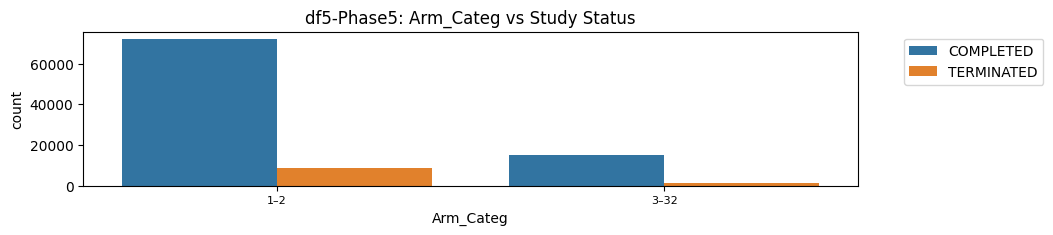

In [657]:
chi2_fun('Arm_Categ', dfi, i)
#### Log_Fun
Arm_Categ = log_fun('Arm_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [658]:
Arm_Counts_aic = fun_compare(i, Arm_Counts = Arm_Counts[0], Arm_Categ = Arm_Categ[0])

## Interventions

### Intervention_Model_List


df5-Phase5:
Intervention_Model_List vs Study Status


Intervention_Model_List,CROSSOVER,FACTORIAL,PARALLEL,SEQUENTIAL,SINGLE_GROUP
Study_Status_Bin,,,,,
COMPLETED,8894,1582,55936,1098,20141
TERMINATED,656,117,5940,98,3312


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97774
Model:                          Logit   Df Residuals:                    97769
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.008236
Time:                        21:18:40   Log-Likelihood:                -32269.
converged:                       True   LL-Null:                       -32537.
Covariance Type:            nonrobust   LLR p-value:                1.125e-114
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8053      0.019     96.276      0.000       1.769       1.842
CROSSOVER      0.8012      0.045     17.970      0.000       0.714       0.889
FACTORIAL      0.7984      0.098      8.180      0.0

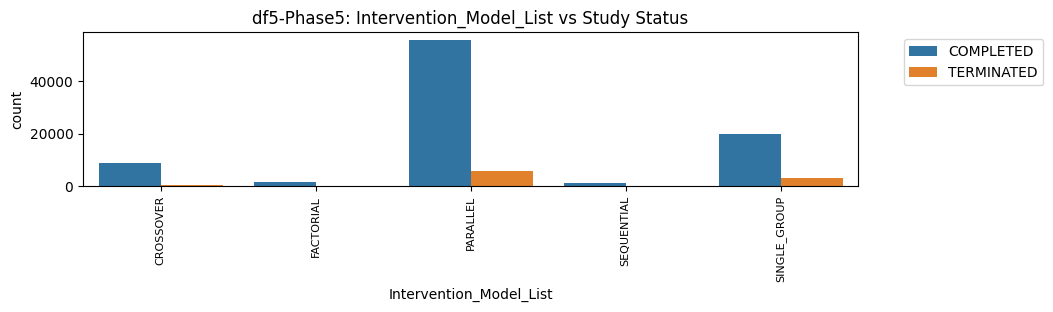

In [659]:
Intervention_Model_List = log_fun("Intervention_Model_List", dfi, i, 'list', False, 90, 'SINGLE_GROUP' )

### Intervention_Type_List


df5-Phase5:
Intervention_Type_List vs Study Status


Intervention_Type_List,BEHAVIORAL,BIOLOGICAL,COMBINATION_PRODUCT,DEVICE,DIAGNOSTIC_TEST,DIETARY_SUPPLEMENT,DRUG,GENETIC,INTERV_OTHER,PROCEDURE,RADIATION
Study_Status_Bin,,,,,,,,,,,
COMPLETED,19755,545,260,17798,1823,5128,5588,121,29691,9834,552
TERMINATED,1502,99,18,3378,252,340,869,19,2792,1380,176


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97820
Method:                           MLE   Df Model:                           10
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.02080
Time:                        21:18:40   Log-Likelihood:                -31886.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                5.848e-285
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.3604      0.018    129.144      0.000       2.325       2.396
BEHAVIORAL              0.2466      0.032      7.767      0.000       0.184       0.309
BIOLOGICAL      

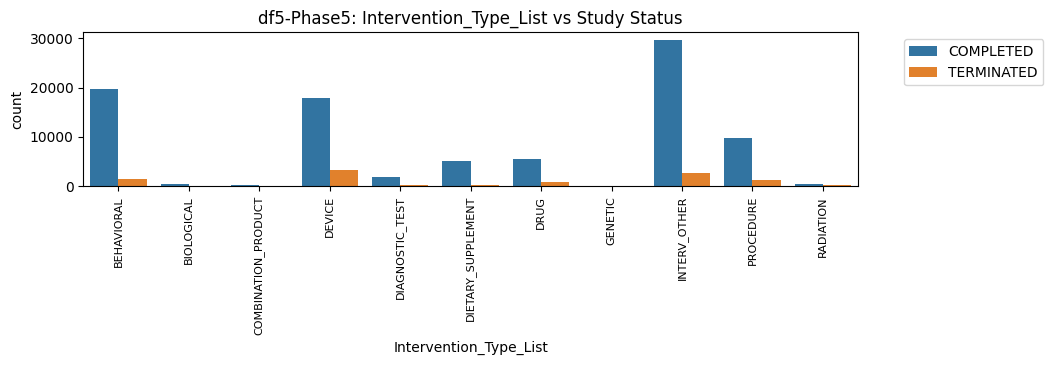

In [660]:
Intervention_Type_List = log_fun("Intervention_Type_List", dfi, i, 'list', False, 90, 'INTERV_OTHER')

### Intervention_Type_Counts


df5-Phase5:
Intervention_Type_Counts vs Study Status


count    97831.000000
mean         1.041797
std          0.214283
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: Intervention_Type_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.002267
Time:                        21:18:41   Log-Likelihood:                -32489.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 5.667e-34
                               coef    std err          z      P>|z|      [0.025      0.

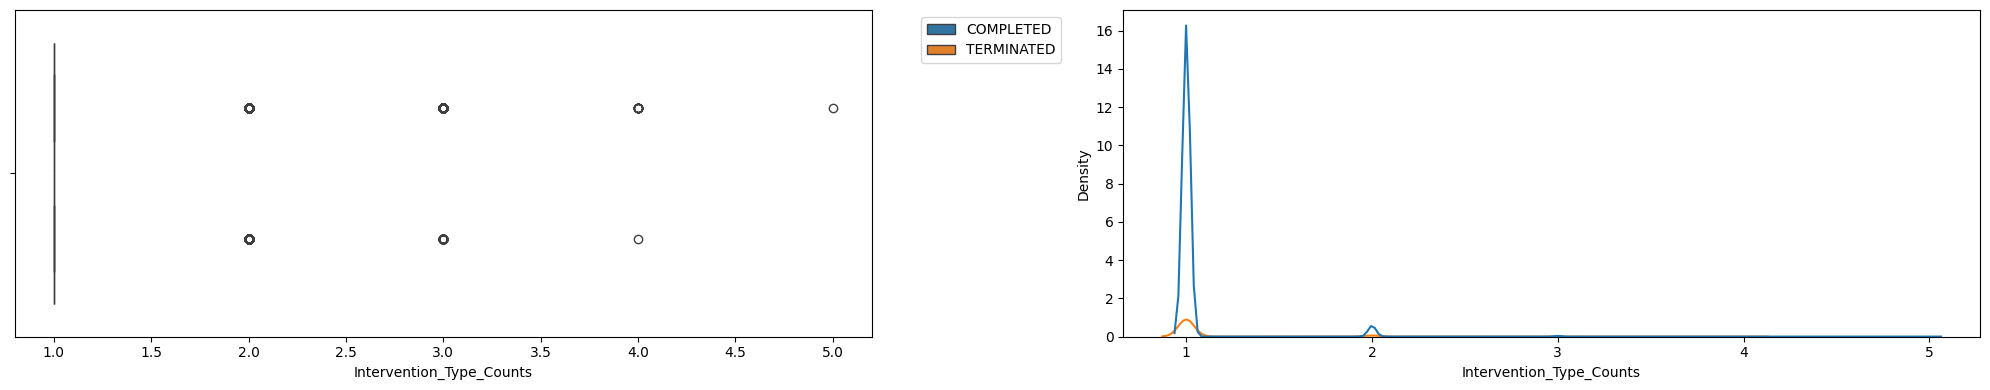

In [661]:
Intervention_Type_Counts = log_fun_cont("Intervention_Type_Counts", dfi, i)

### Intervention_Type_Categ

df5-Phase5:
df5-Phase5: Intervention_Type_Categ vs Study Status
df5-Phase5, Intervention_Type_Categ p-value:
5.933073166715181e-39
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Intervention_Type_Categ vs Study Status


Intervention_Type_Categ,1,2–5
Study_Status_Bin,,
COMPLETED,84517,3182
TERMINATED,9495,637


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.002278
Time:                        21:18:42   Log-Likelihood:                -32489.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 3.945e-34
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.1863      0.011    201.984      0.000       2.165       2.207
Intervention_Type_Categ    -0.5787      0.045    -12.940      0.000      -0.666      -0.491


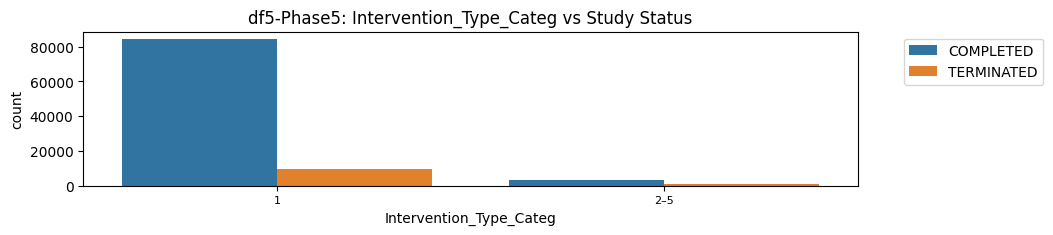

In [662]:
chi2_fun('Intervention_Type_Categ', dfi, i)
#### log_fun
Intervention_Type_Categ = log_fun('Intervention_Type_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [663]:
Intervention_Type_Counts_aic = fun_compare(i, Intervention_Type_Counts = Intervention_Type_Counts[0], Intervention_Type_Categ = Intervention_Type_Categ[0])

### Intervention_Method_List

df5-Phase5:
Intervention_Method_List vs Study Status


Intervention_Method_List,Injection,Inter_Meth_Other,Oral,Surgical,Topical
Study_Status_Bin,,,,,
COMPLETED,27488,39120,11559,15473,10191
TERMINATED,3256,3951,1023,2589,1567


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97826
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.008843
Time:                        21:18:43   Log-Likelihood:                -32275.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                2.497e-123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2873      0.015    151.123      0.000       2.258       2.317
Injection     -0.0085      0.023     -0.373      0.709      -0.053       0.036
Oral           0.2707      0.035      7.817      0.0

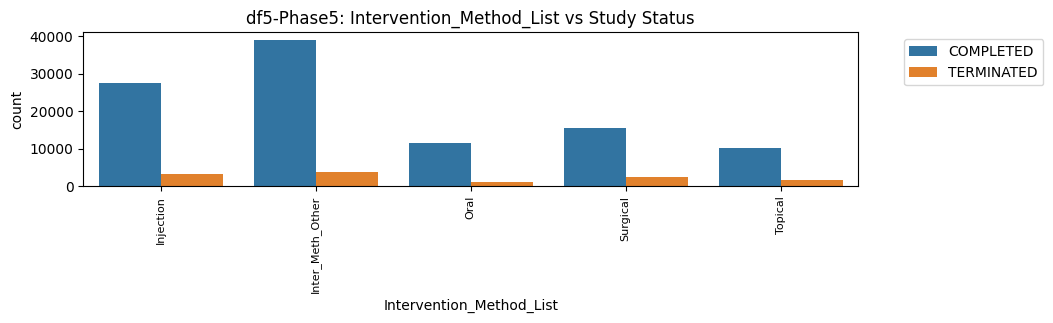

In [664]:
Intervention_Method_List = log_fun("Intervention_Method_List", dfi, i, 'list', False, 90, 'Inter_Meth_Other')

### Intervention_Method_Counts

df5-Phase5:
Intervention_Method_Counts vs Study Status


count    97831.000000
mean         1.187936
std          0.437586
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: Intervention_Method_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001028
Time:                        21:18:43   Log-Likelihood:                -32529.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 2.799e-16
                                 coef    std err          z      P>|z|      [0.025  

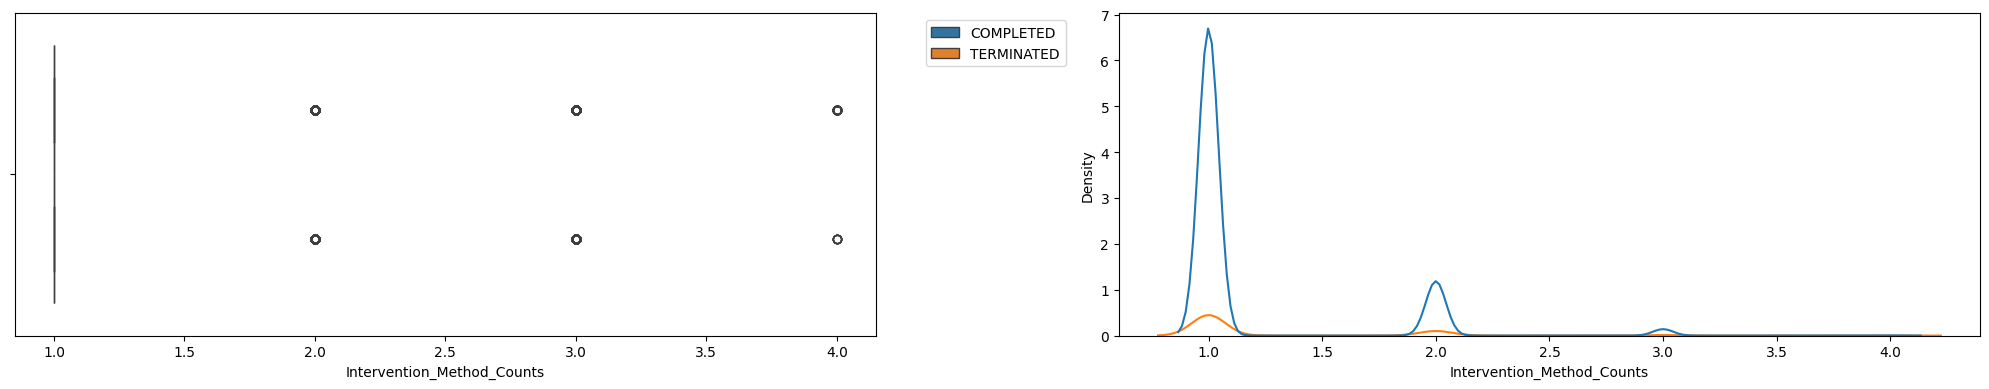

In [665]:
Intervention_Method_Counts = log_fun_cont("Intervention_Method_Counts", dfi, i)

### Intervention_Method_Categ

df5-Phase5:
df5-Phase5: Intervention_Method_Categ vs Study Status
df5-Phase5, Intervention_Method_Categ p-value:
4.1670744487347325e-18
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Intervention_Method_Categ vs Study Status


Intervention_Method_Categ,1,2–4
Study_Status_Bin,,
COMPLETED,73185,14514
TERMINATED,8109,2023


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001114
Time:                        21:18:45   Log-Likelihood:                -32527.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.626e-17
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.2000      0.012    187.971      0.000       2.177       2.223
Intervention_Method_Categ    -0.2295      0.026     -8.672      0.000      -0.281     

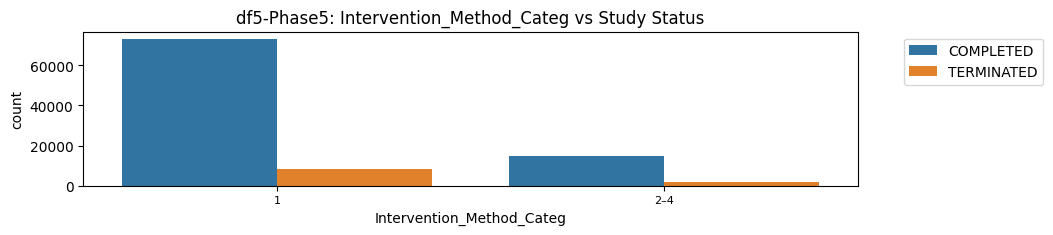

In [666]:
chi2_fun('Intervention_Method_Categ', dfi, i)
#### Log_Fun
Intervention_Method_Categ = log_fun('Intervention_Method_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [667]:
Intervention_Method_Counts_aic = fun_compare(i, Intervention_Method_Counts = Intervention_Method_Counts[0], 
                                             Intervention_Method_Categ = Intervention_Method_Categ[0])

## Locations

### City_Counts

df5-Phase5:
City_Counts vs Study Status


count    97831.000000
mean         1.581963
std          4.980605
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        691.000000
Name: City_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               8.748e-06
Time:                        21:18:45   Log-Likelihood:                -32563.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.4504
                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

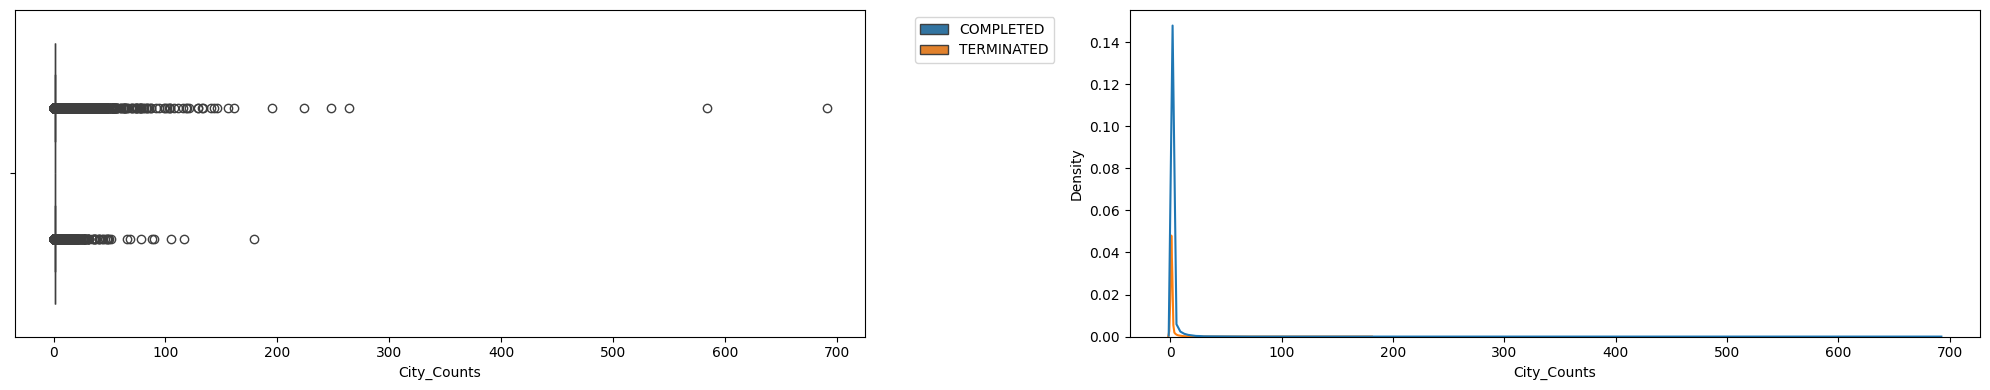

In [668]:
City_Counts = log_fun_cont("City_Counts", dfi, i)

### City_Categ

df5-Phase5:
df5-Phase5: City_Categ vs Study Status
df5-Phase5, City_Categ p-value:
1.3754179090391275e-06
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
City_Categ vs Study Status


City_Categ,0–1,2–691
Study_Status_Bin,,
COMPLETED,77316,10383
TERMINATED,8765,1367


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0003497
Time:                        21:18:46   Log-Likelihood:                -32552.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.819e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1771      0.011    193.171      0.000       2.155       2.199
City_Categ    -0.1496      0.031     -4.841      0.000      -0.210      -0.089


df5-Phase5, City_Categ p-values:
[const         0.

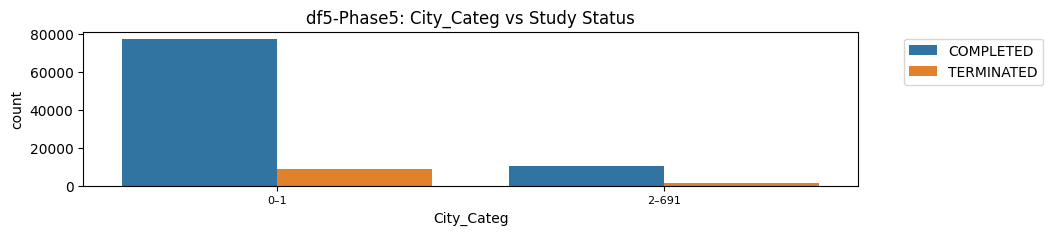

In [669]:
chi2_fun('City_Categ', dfi, i)
#### log_fun
City_Categ = log_fun('City_Categ', dfi, i, 'bin', False, 0)

#### AIC

In [670]:
City_Counts_aic = fun_compare(i, City_Counts = City_Counts[0], City_Categ = City_Categ[0])

### Country_Counts


df5-Phase5:
Country_Counts vs Study Status


count    97831.000000
mean         0.993693
std          0.653732
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         49.000000
Name: Country_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0001099
Time:                        21:18:47   Log-Likelihood:                -32559.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                  0.007471
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

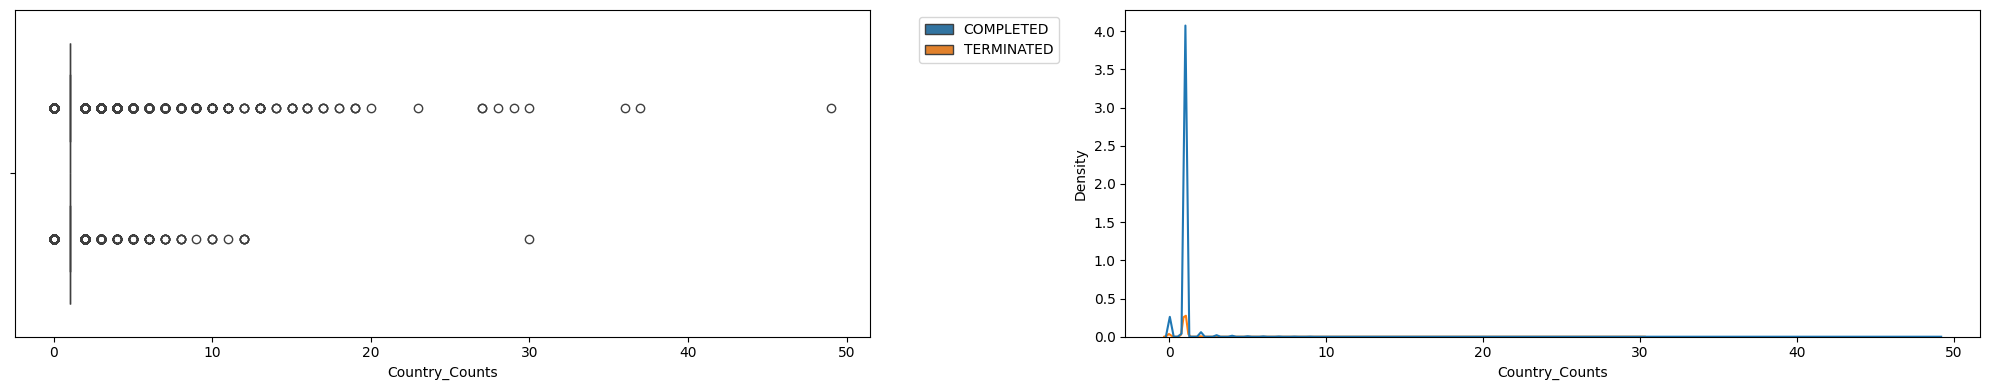

In [671]:
Country_Counts = log_fun_cont("Country_Counts", dfi, i)

### Country_Categ

df5-Phase5:
df5-Phase5: Country_Categ vs Study Status
df5-Phase5, Country_Categ p-value:
7.522857261796798e-05
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Country_Categ vs Study Status


Country_Categ,0–1,2–49
Study_Status_Bin,,
COMPLETED,85648,2051
TERMINATED,9830,302


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0002298
Time:                        21:18:48   Log-Likelihood:                -32555.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 0.0001094
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.1648      0.011    203.284      0.000       2.144       2.186
Country_Categ    -0.2496      0.063     -3.990      0.000      -0.372      -0.127


df5-Phase5, Country_Categ p-values:
[c

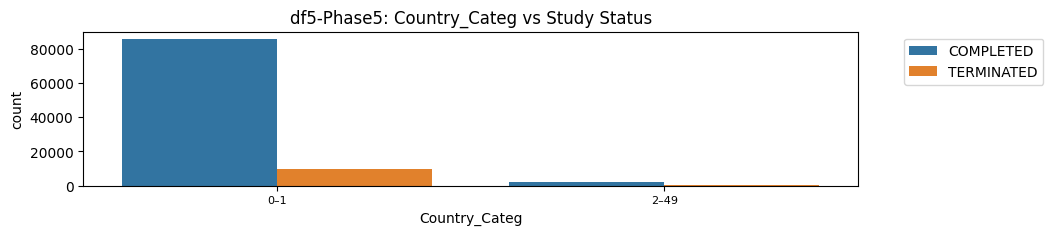

In [672]:
chi2_fun('Country_Categ', dfi, i)
#### log_fun
Country_Categ = log_fun('Country_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [673]:
Country_Counts_aic = fun_compare(i, Country_Counts = Country_Counts[0], Country_Categ = Country_Categ[0])

### Continents_List 

df5-Phase5:
Continents_List vs Study Status


Continents_List,Africa,Asia,Cont_None,Europe,North America,Oceania,South America
Study_Status_Bin,,,,,,,
COMPLETED,4828,17325,7913,25012,31076,578,2285
TERMINATED,85,680,1065,2705,5575,79,125


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97824
Method:                           MLE   Df Model:                            6
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.04001
Time:                        21:18:49   Log-Likelihood:                -31260.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.0848      0.032     65.815      0.000       2.023       2.147
Africa            1.9489      0.114     17.147      0.000       1.726       2.172
Asia              1.1519      0.050     

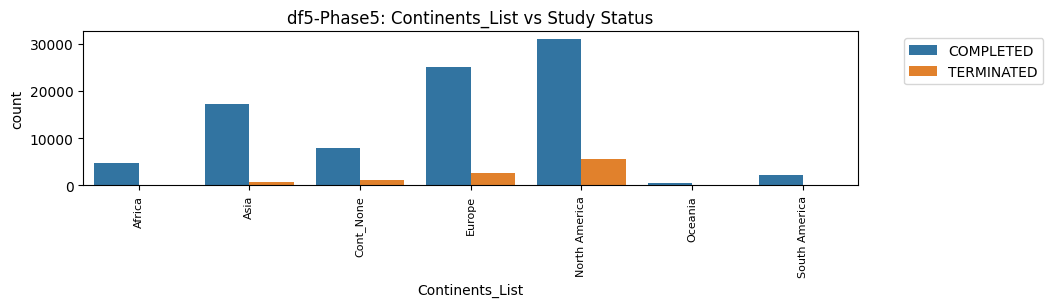

In [674]:
Continents_List = log_fun("Continents_List", dfi, i, 'list', False, 90, 'Cont_None')

### Continent_Counts

df5-Phase5:
Continent_Counts vs Study Status


count    97831.000000
mean         0.923562
std          0.334166
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: Continent_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0001778
Time:                        21:18:49   Log-Likelihood:                -32557.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 0.0006659
                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------

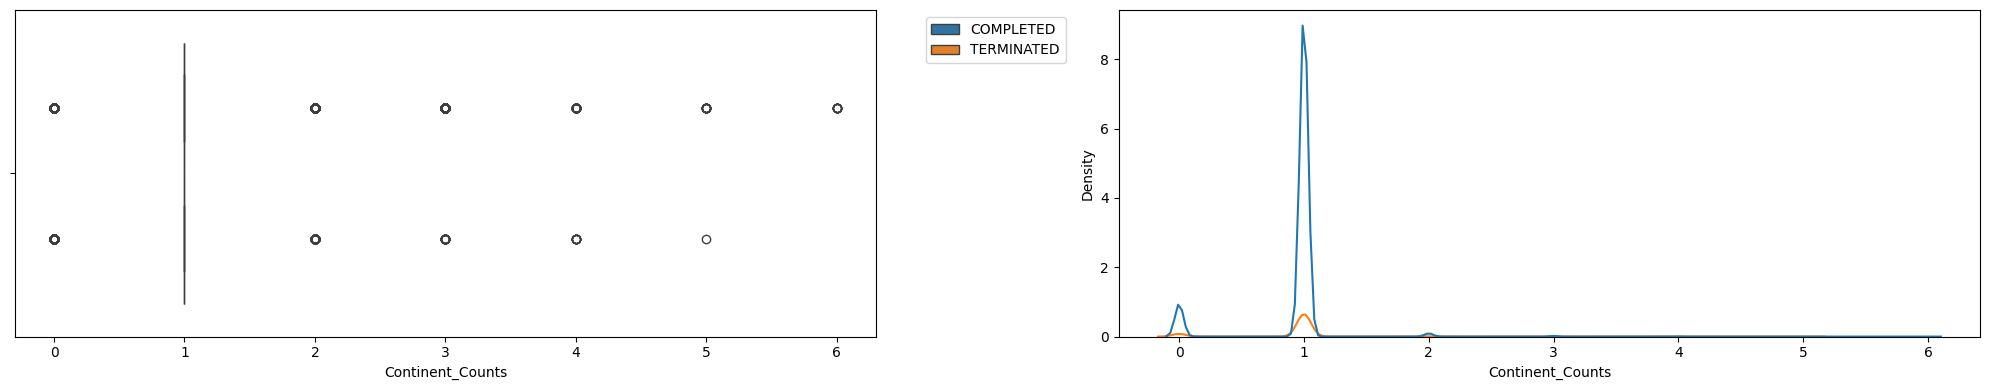

In [675]:
Continent_Counts = log_fun_cont("Continent_Counts", dfi, i)

### Continent_Categ

df5-Phase5:
df5-Phase5: Continent_Categ vs Study Status
df5-Phase5, Continent_Categ p-value:
0.09031298937509953
No significant difference


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Continent_Categ vs Study Status


Continent_Categ,0–1,2–6
Study_Status_Bin,,
COMPLETED,86702,997
TERMINATED,9997,135


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               4.472e-05
Time:                        21:18:50   Log-Likelihood:                -32562.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                   0.08790
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.1603      0.011    204.519      0.000       2.140       2.181
Continent_Categ    -0.1623      0.092     -1.760      0.078      -0.343       0.018


df5-Phase5, Continent_Categ p-

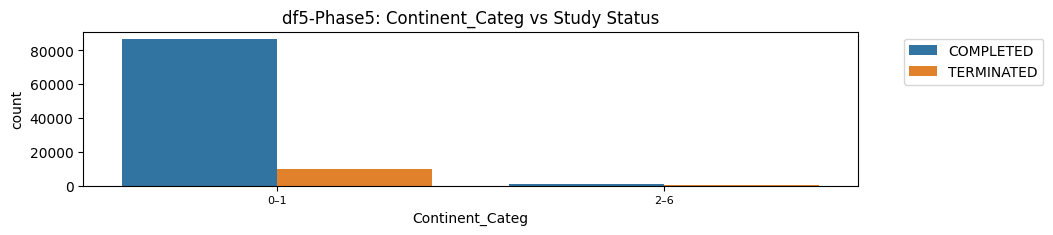

In [676]:
chi2_fun('Continent_Categ', dfi, i)
#### log_fun
Continent_Categ = log_fun('Continent_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [677]:
Continent_Counts_aic = fun_compare(i, Continent_Counts = Continent_Counts[0], Continent_Categ = Continent_Categ[0])

#### AIC_all

In [678]:
Locations_aic_all = fun_compare(i, City_Counts = City_Counts[0],
                                City_Categ = City_Categ[0], 
                            Country_Counts = Country_Counts[0], 
                            Country_Categ = Country_Categ[0],
                            Continent_Counts = Continent_Counts[0],
                            Continent_Categ = Continent_Categ[0])

## Datetimes

### Start_Date_Year_Counts

df5-Phase5:
Start_Date_Year_Counts vs Study Status


count        97831.0
mean     2017.454917
std         3.488602
min           2011.0
25%           2015.0
50%           2018.0
75%           2020.0
max           2024.0
Name: Start_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001197
Time:                        21:18:51   Log-Likelihood:                -32524.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.054e-18
                             coef    std err          z      P>|z|      [0.025      0.975]
---------

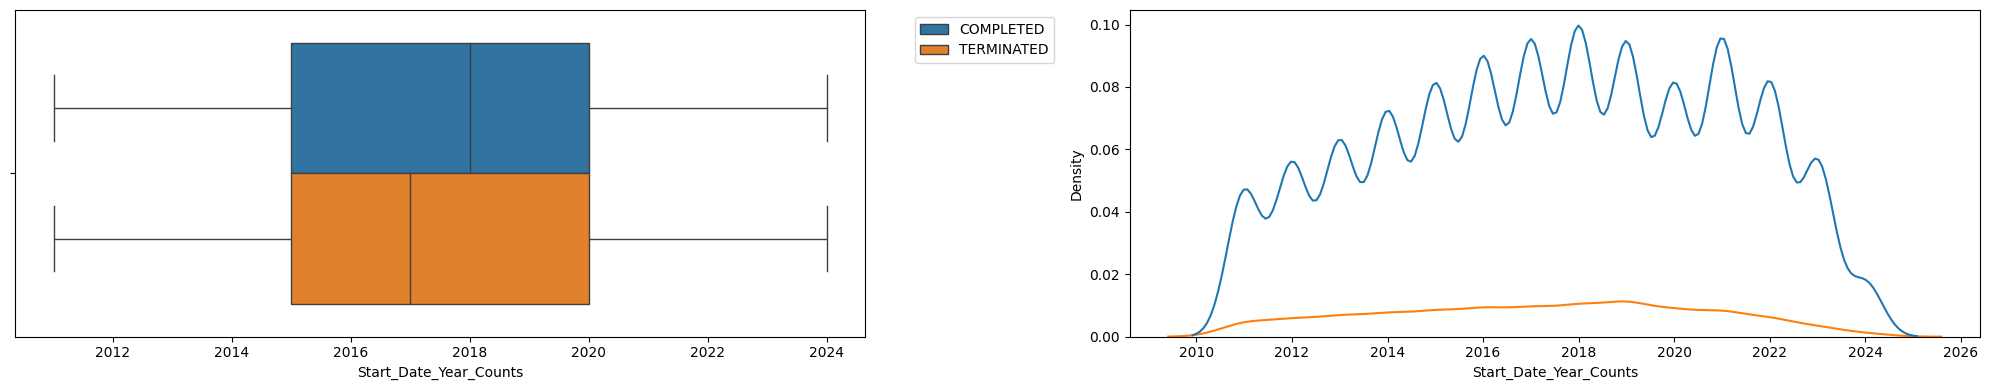

In [679]:
Start_Date_Year_Counts = log_fun_cont("Start_Date_Year_Counts", dfi, i)

### Start_Date_Year_Categ
- Categorization is covid dates oriented

df5-Phase5:
df5-Phase5: Start_Date_Year_Categ vs Study Status
df5-Phase5, Start_Date_Year_Categ p-value:
2.2029907843145628e-08
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Start_Date_Year_Categ vs Study Status


Start_Date_Year_Categ,2011-2018,2019-2024
Study_Status_Bin,,
COMPLETED,51334,36365
TERMINATED,6224,3908


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0004855
Time:                        21:18:52   Log-Likelihood:                -32547.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.878e-08
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.1100      0.013    157.201      0.000       2.084       2.136
Start_Date_Year_Categ     0.1206      0.022      5.602      0.000       0.078       0.163


df5-Ph

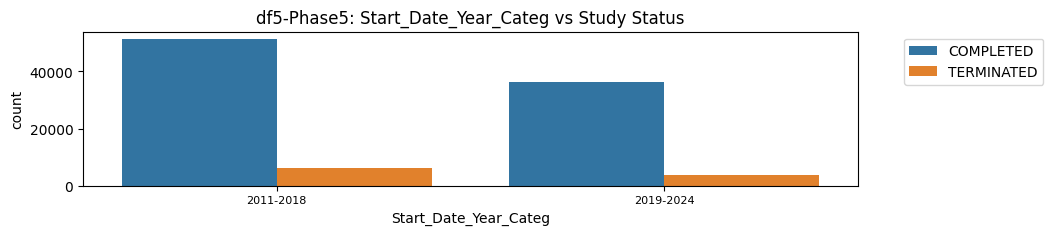

In [680]:
chi2_fun("Start_Date_Year_Categ", dfi, i)
#### log_fun
Start_Date_Year_Categ = log_fun("Start_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### AIC 

In [681]:
# Start_Date_Year_Counts = Start_Date_Year_Counts[0] --> wont be used as year is about to look for post vs past covid patterns.
Start_Date_Year_Counts_aic = fun_compare(i, Start_Date_Year_Categ = Start_Date_Year_Categ[0]) # Keep only category

### Completion_Date_Year 
- will not run AIC --> Date - Year itself is not a feature affecting the outcome.



df5-Phase5:
Completion_Date_Year_Counts vs Study Status


count        97831.0
mean     2019.308849
std         3.232076
min           2011.0
25%           2017.0
50%           2020.0
75%           2022.0
max           2024.0
Name: Completion_Date_Year_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               0.0002361
Time:                        21:18:53   Log-Likelihood:                -32555.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 8.819e-05
                                  coef    std err          z      P>|z|      [0.025      0

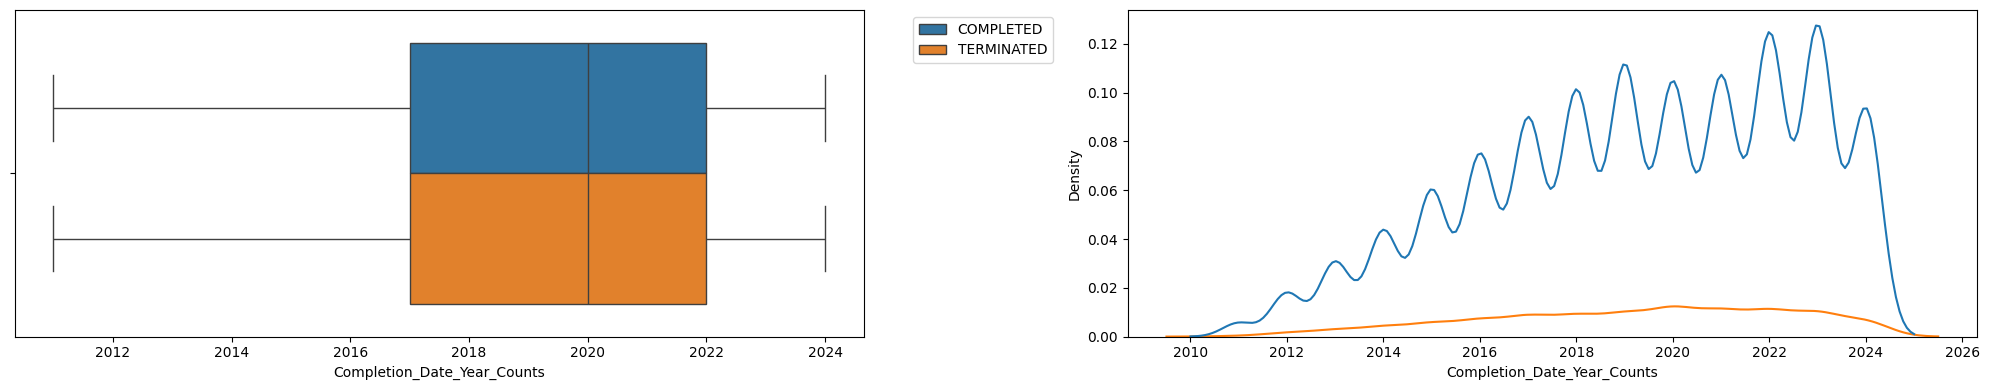

In [682]:
Completion_Date_Year_Counts = log_fun_cont("Completion_Date_Year_Counts", dfi, i)
# Plot is higher to completion as year pass --> Logic as trials of dataset are 2011-2024. 
# At 2011 that all started no trial was finished.

### Completion_Date_Year_Categ
- Categorization is covid dates oriented

df5-Phase5:
df5-Phase5: Completion_Date_Year_Categ vs Study Status
df5-Phase5, Completion_Date_Year_Categ p-value:
0.2428221400646881
No significant difference


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Completion_Date_Year_Categ vs Study Status


Completion_Date_Year_Categ,2011-2018,2019-2024
Study_Status_Bin,,
COMPLETED,34016,53683
TERMINATED,3991,6141


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:               2.130e-05
Time:                        21:18:54   Log-Likelihood:                -32562.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                    0.2389
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.1429      0.017    128.066      0.000       2.110       2.176
Completion_Date_Year_Categ     0.0253      0.021      1.178      0.239      -0.017 

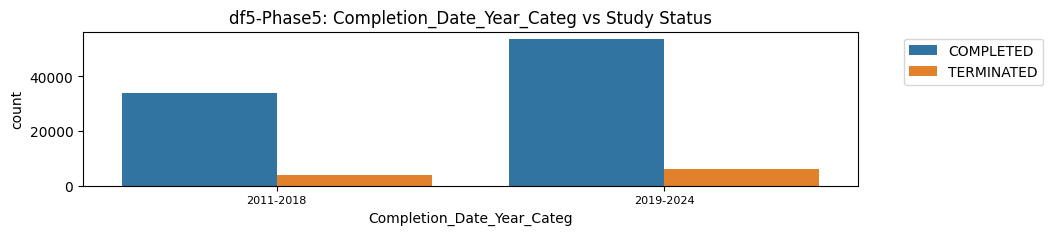

In [683]:
chi2_fun("Completion_Date_Year_Categ", dfi, i)
### log_fun
Completion_Date_Year_Categ = log_fun("Completion_Date_Year_Categ", dfi, i, 'bin', True, 0)

#### AIC

In [684]:
# Completion_Date_Year_Counts = Completion_Date_Year_Counts[0] --> wont be used as year is about to look for post vs past covid patterns.
Completion_Date_Year_Counts_aic = fun_compare(i, Completion_Date_Year_Categ = Completion_Date_Year_Categ[0]) # keep only category

#### AIC_all


In [685]:
Date_Year_aic_all = fun_compare(i, Start_Date_Year_Categ = Start_Date_Year_Categ[0], Completion_Date_Year_Categ = Completion_Date_Year_Categ[0])

### Completion_Gap_Counts

- Notice Termination main Distribution median = Around 20 participants --> cutpoint

df5-Phase5:
Completion_Gap_Counts vs Study Status


count      97831.0
mean     22.925443
std      20.217512
min            0.0
25%            8.0
50%           17.0
75%           32.0
max          157.0
Name: Completion_Gap_Counts, dtype: Float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.001459
Time:                        21:18:55   Log-Likelihood:                -32515.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.902e-22
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

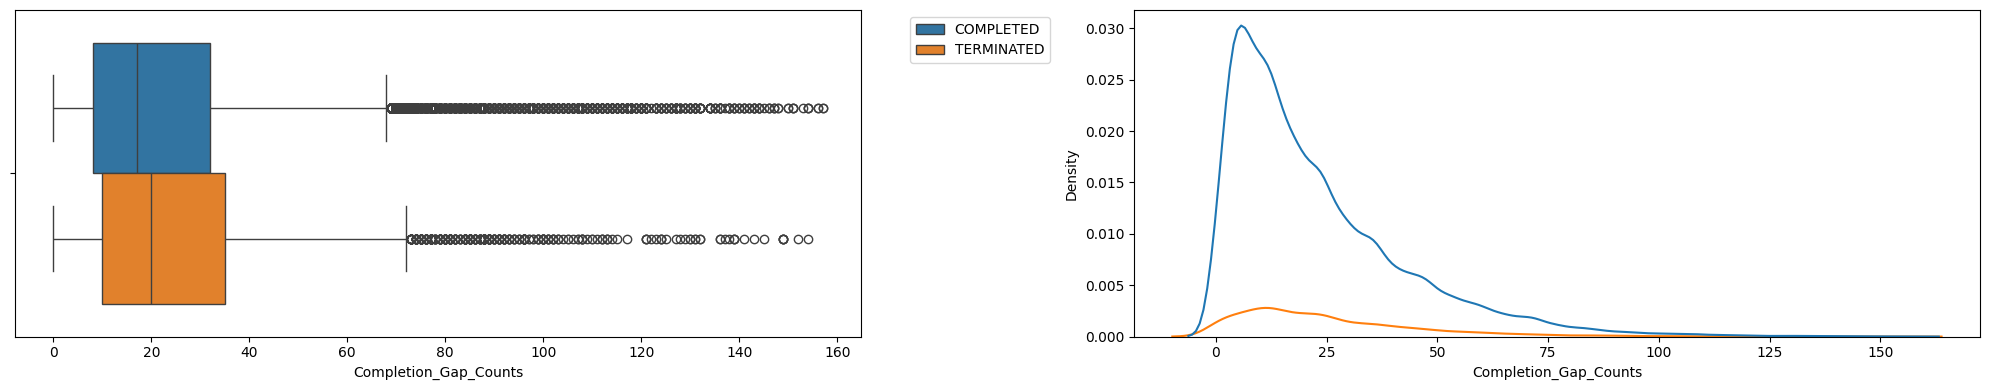

In [686]:
Completion_Gap_Counts = log_fun_cont("Completion_Gap_Counts", dfi, i)

### Completion_Gap_Categ

df5-Phase5:
df5-Phase5: Completion_Gap_Categ vs Study Status
df5-Phase5, Completion_Gap_Categ p-value:
2.1164379579371482e-38
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Completion_Gap_Categ vs Study Status


Completion_Gap_Categ,0–17,18–157
Study_Status_Bin,,
COMPLETED,45133,42566
TERMINATED,4525,5607


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97831
Model:                          Logit   Df Residuals:                    97829
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                0.002585
Time:                        21:18:56   Log-Likelihood:                -32479.
converged:                       True   LL-Null:                       -32563.
Covariance Type:            nonrobust   LLR p-value:                 1.676e-38
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.3002      0.016    147.500      0.000       2.270       2.331
Completion_Gap_Categ    -0.2731      0.021    -12.945      0.000      -0.314      -0.232


df5-Phase5

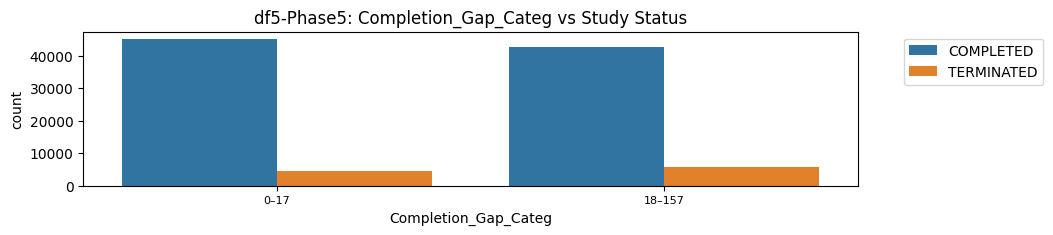

In [687]:
chi2_fun('Completion_Gap_Categ', dfi, i)
#### log_fun
Completion_Gap_Categ = log_fun('Completion_Gap_Categ', dfi, i, 'bin', True, 0)

#### AIC 

In [688]:
Completion_Gap_Counts_aic = fun_compare(i, Completion_Gap_Counts = Completion_Gap_Counts[0], Completion_Gap_Categ = Completion_Gap_Categ[0])

## Enrollment

### Enrollment_Counts

df5-Phase5:
Enrollment_Counts vs Study Status


count    9.780100e+04
mean     1.065257e+03
std      7.888849e+04
min      0.000000e+00
25%      2.400000e+01
50%      5.200000e+01
75%      1.120000e+02
max      2.012121e+07
Name: Enrollment_Counts, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97801
Model:                          Logit   Df Residuals:                    97799
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.02181
Time:                        21:18:57   Log-Likelihood:                -31845.
converged:                       True   LL-Null:                       -32555.
Covariance Type:            nonrobust   LLR p-value:                1.077e-310
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------

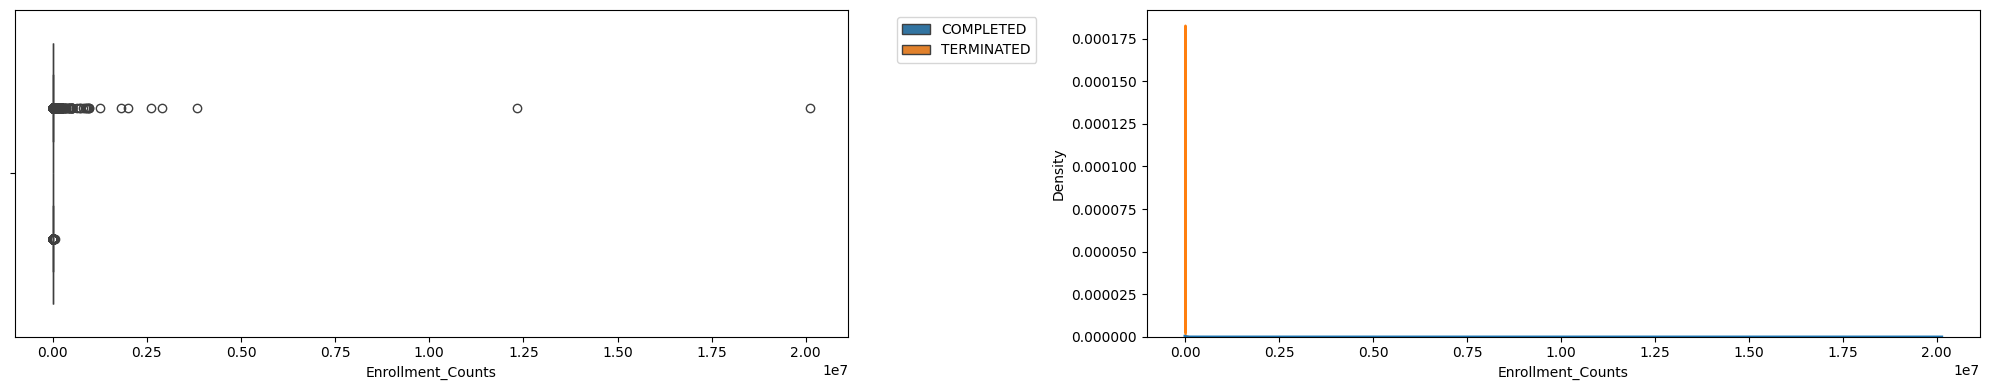

In [689]:
Enrollment_Counts = log_fun_cont("Enrollment_Counts", dfi, i)

### Enrollment_Counts_Log

df5-Phase5:
Enrollment_Counts_Log vs Study Status


count    97801.000000
mean         3.985912
std          1.540342
min          0.000000
25%          3.218876
50%          3.970292
75%          4.727388
max         16.817285
Name: Enrollment_Counts_Log, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97801
Model:                          Logit   Df Residuals:                    97799
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                  0.3571
Time:                        21:18:58   Log-Likelihood:                -20931.
converged:                       True   LL-Null:                       -32555.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
----

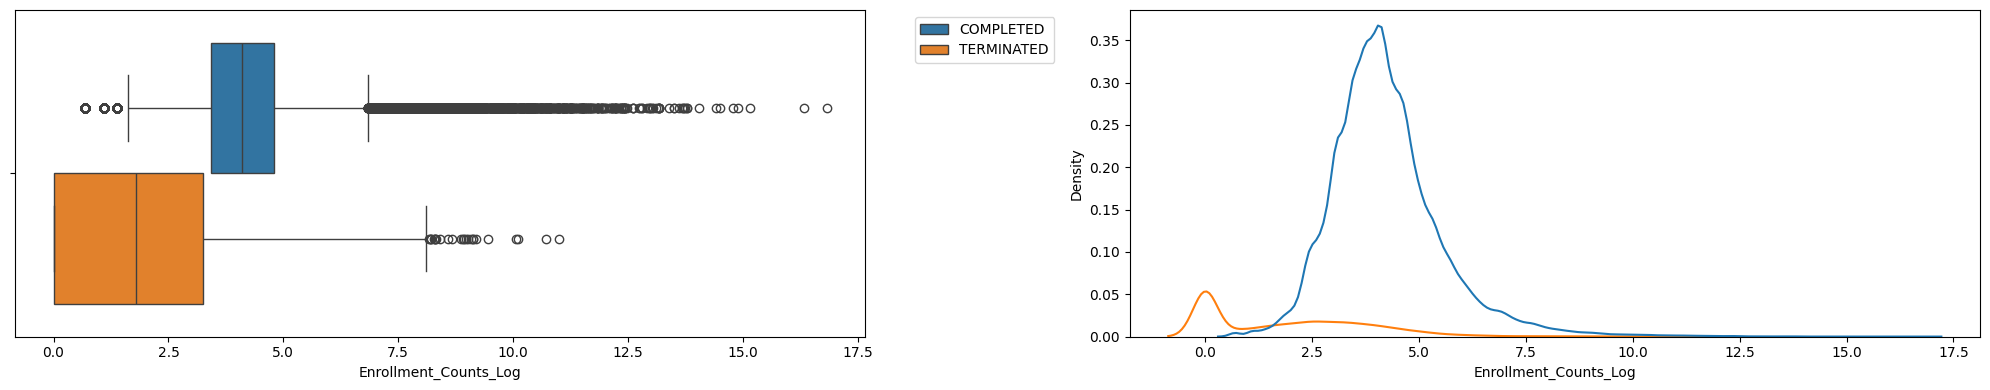

In [690]:
Enrollment_Counts_Log = log_fun_cont("Enrollment_Counts_Log", dfi, i)

### Enrollement_Sqrt

df5-Phase5:
Enrollment_Counts_Sqrt vs Study Status


count    97801.000000
mean        10.688170
std         30.838774
min          0.000000
25%          4.898979
50%          7.211103
75%         10.583005
max       4485.667397
Name: Enrollment_Counts_Sqrt, dtype: float64


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97801
Model:                          Logit   Df Residuals:                    97799
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                  0.2223
Time:                        21:18:59   Log-Likelihood:                -25317.
converged:                       True   LL-Null:                       -32555.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
-

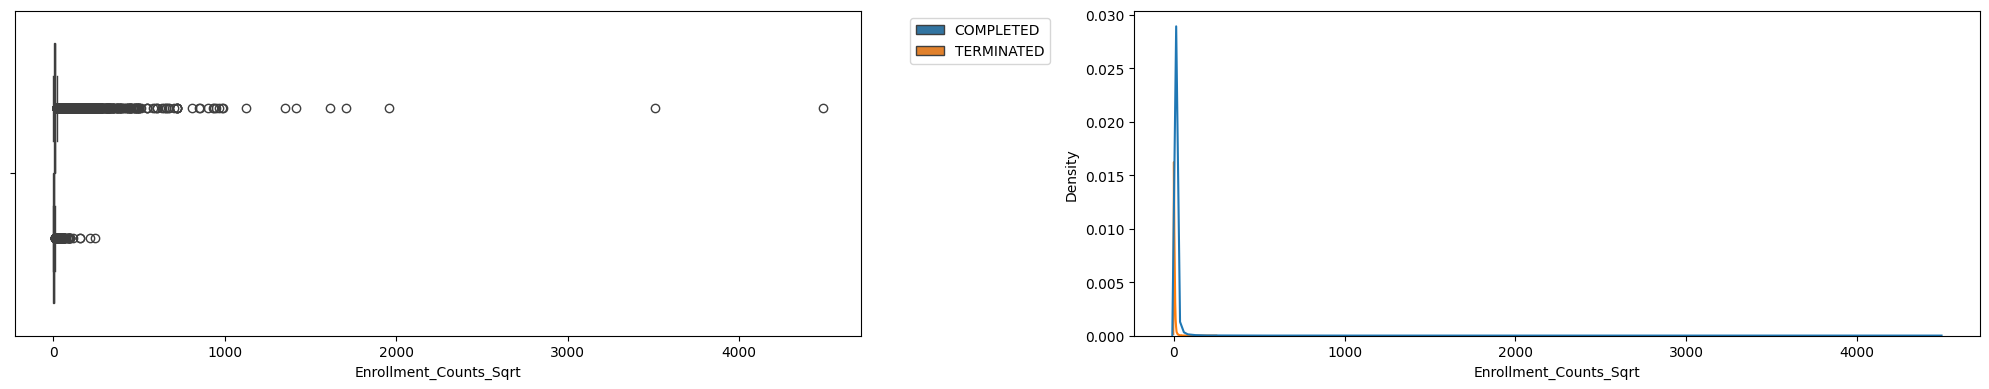

In [691]:
Enrollment_Counts_Sqrt = log_fun_cont("Enrollment_Counts_Sqrt", dfi, i)

### Enrollment_Categ
- See Enrollment Plot as Continues below. Better Plot as continues (BoxPlot)

df5-Phase5:
df5-Phase5: Enrollment_Categ vs Study Status
df5-Phase5, Enrollment_Categ p-value:
0.0
P-value < 0.05


------------------------------------------------------------------------------------------------------------

df5-Phase5:
Enrollment_Categ vs Study Status


Enrollment_Categ,0–52,53–20121212
Study_Status_Bin,,
COMPLETED,40786,46885
TERMINATED,8659,1471


                           Logit Regression Results                           
Dep. Variable:       Study_Status_Bin   No. Observations:                97801
Model:                          Logit   Df Residuals:                    97799
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Aug 2025   Pseudo R-squ.:                 0.09310
Time:                        21:19:00   Log-Likelihood:                -29525.
converged:                       True   LL-Null:                       -32555.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.5498      0.012    130.976      0.000       1.527       1.573
Enrollment_Categ     1.9120      0.029     65.925      0.000       1.855       1.969


df5-Phase5, Enrollment_Cat

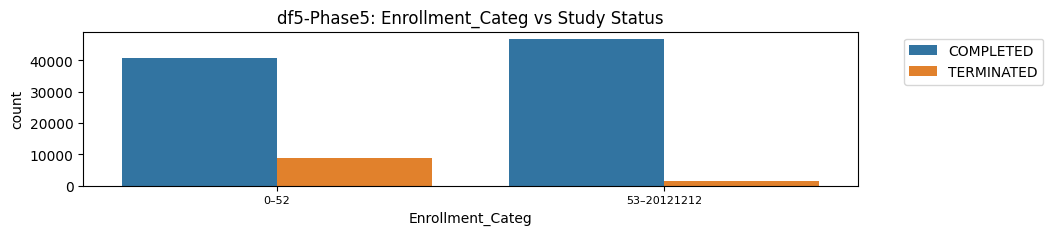

In [692]:
chi2_fun("Enrollment_Categ", dfi, i)
#### log_fun
Enrollment_Categ = log_fun('Enrollment_Categ', dfi, i, 'bin', True, 0)

#### AIC

In [693]:
Enrollemnt_Counts_aic = fun_compare(i, Enrollment_Counts = Enrollment_Counts[0], 
                                    Enrollment_Counts_Log = Enrollment_Counts_Log[0], 
                                    Enrollment_Counts_Sqrt = Enrollment_Counts_Sqrt[0], 
                                    Enrollment_Categ = Enrollment_Categ[0])

# # AICS / Drop cols
Drop cols that are not going to be used in analysis.

## Drop_Cols

In [694]:
dfi = dfi.drop(columns = [
# unique identifiers of trials, not status associated.
        "Study Title", "official_title", "Other IDs", "Acronym", "Study URL", 'Brief Summary', "nct_id", 
# used through as other columns
        "Study Type", "Study Design", "Interventions", 'Conditions', 
 # Actual Dates trials happened is not reason for status.
        "Start Date", "Completion Date", "Primary Completion Date",
        "First Posted", "Results First Posted", "Last Update Posted",    
        "Start_Date_Year_Categ", "Start_Date_Year_Counts" , "Completion_Date_Year_Categ", "Completion_Date_Year_Counts",
# used merged in another column
        'Sponsor', 'Collaborators',
# text data/many categorize --> used continents/country counts insted.
        "Countries_List", "Locations", 
# 145k trials with non uploaded Documents --> not logical sample        
        "Study Documents", 'Study_Documents_List', 'Document_Counts', 'Document_Bin',
 # Outcomes are a Study result not a pre - Designed characteristic
        "Study Results",
        'Primary Outcome Measures', 'Secondary Outcome Measures', 'Other Outcome Measures',
        'Outcomes_List', 'Outcomes_Counts', 'Outcomes_Bin',
        'Injection', 'Oral', 'Topical','Surgical',       
        ] , axis = 1)

In [695]:
dfi.shape

(97831, 47)

## AIC_Total
- AIC_Total test is used to select Count cols format. (e.g. Continues vs Log vs Categorical etc. )

In [696]:
aics = [
        # Adverse_Counts_aic, Adverse_Detail_Counts_aic --> Counts used as Adv_Bin
        # Start_Date_Year_Counts_aic, Completion_Date_Year_Counts_aic,
        Arm_Counts_aic,
        Intervention_Type_Counts_aic, Intervention_Method_Counts_aic,
        # City_Counts_aic, Country_Counts_aic, Continent_Counts_aic, 
        Completion_Gap_Counts_aic, 
        Enrollemnt_Counts_aic]

for idx in range(len(aics)):
    aic = aics[idx]
    for col in aic.columns:
        if '_' in col:
            new_col = col.split('_')[-1]
            aic.rename(columns = {col: new_col}, inplace = True)
    aics[idx] = aic
# aics[-2] # Example

AIC_Total = pd.concat(aics, ignore_index = False)
AIC_Total = AIC_Total.rename(columns = {'min' : 'AIC_Min'})
AIC_Total = AIC_Total.reindex(labels = ['Counts', 'Log', 'Sqrt', 'Categ', 'Bin', 'AIC_Min'], axis = 1)
AIC_Total

,Counts,Log,Sqrt,Categ,Bin,AIC_Min
df5,,,,,,
Arm_Counts,[64285.0],NaN,NaN,[64468.0],NaN,Arm_Counts
Intervention_Type_Counts,[64982.0],NaN,NaN,[64982.0],NaN,Intervention_Type_Counts
Intervention_Method_Counts,[65063.0],NaN,NaN,[65057.0],NaN,Intervention_Method_Categ
Completion_Gap_Counts,[65035.0],NaN,NaN,[64962.0],NaN,Completion_Gap_Categ
Enrollment_Counts,[63695.0],[41865.0],[50639.0],[59053.0],NaN,Enrollment_Counts_Log


## AIC_all
- AIC test is used to exclude similar information variables and their dtype formats. Facilitry counts must used through one variable.
(e.g Country_Counts vs Continent Counts vs Continent_Categ)

In [697]:
aic_all = [
    Conditions_aic_all,
    Adverse_aic_all,
    Adverse_Counts_aic_all,
    # Masking_aic_all,  
    Locations_aic_all,
    # Date_Year_aic_all --> dropped above
]

aic_all1 = pd.concat([df_aic[['AIC_min']] for df_aic in aic_all])
display(aic_all1)

drop_cols = []

for df_aic in aic_all:
    if 'AIC_min' in df_aic.columns:
        keep_col = df_aic['AIC_min'].iloc[0]
        candidates = [col for col in df_aic.columns if col != 'AIC_min']
        drop_col = [col for col in candidates if col != keep_col]
        drop_cols.append(drop_col)

drop_cols = list(chain.from_iterable(drop_cols))
display(drop_cols)

dfi = dfi.drop(columns = drop_cols, axis = 1)

,AIC_min
df5,
Conditions_List,Conditions_Detail_List
Adverse_List,Adverse_Detail_List
Adverse_Detail_Counts,Adverse_Counts_Log
City_Counts,City_Categ


['Conditions_List',
 'Adverse_List',
 'Adverse_Detail_Counts',
 'Adverse_Detail_Counts_Log',
 'Adverse_Detail_Counts_Sqrt',
 'Adverse_Counts',
 'Adverse_Counts_Sqrt',
 'City_Counts',
 'Country_Counts',
 'Country_Categ',
 'Continent_Counts',
 'Continent_Categ']

## keep Cols

In [698]:
keep_cols = AIC_Total['AIC_Min'].tolist() + aic_all1['AIC_min'].tolist()
keys = ['_list', '_bin', 'phase', 'status'] 
# All Count Cols have been and choosen from above AIC tests
# Status --> Study_Status_Bin / PHASE --> PHASES0, 1 etc
# _List, _Bin cols --> Not used in AIC tests --> include them eitherway
 
keep_cols1 = [col for col in dfi.columns if any(k in col.lower() for k in keys)]
keep_cols = list(set(keep_cols + keep_cols1))

dfi = dfi[keep_cols]
keep_cols

['Placebo_Bin',
 'Covid_19_Bin',
 'Healthy_Bin',
 'Age_List',
 'Masking_List',
 'Enrollment_Counts_Log',
 'City_Categ',
 'Standard_Care_Bin',
 'Completion_Gap_Categ',
 'Masking_Detail_List',
 'Arm_Counts',
 'Primary_Purpose_List',
 'Sex_List',
 'Intervention_Model_List',
 'Adverse_Bin',
 'Study_Status_Bin',
 'Conditions_Detail_List',
 'Intervention_Method_List',
 'Intervention_Type_List',
 'Intervention_Type_Counts',
 'Adverse_Counts_Log',
 'Adverse_Detail_List',
 'Allocation_List',
 'Intervention_Method_Categ',
 'Funder_Type_List',
 'Continents_List']

## P_Value/ CL : Univariable 

In [699]:
# cls df
cl_vars = keep_cols.copy()
cl_list = [globals()[var][2][1:] for var in cl_vars if var!= 'Study_Status_Bin']  
cls = pd.concat(cl_list, axis = 0).reset_index(drop = False)
cls = cls.rename(columns = {'index': 'Variable', 0: 'Lower_CL', 1: 'Upper_CL'})
cls[['Lower_CL', 'Upper_CL']] = cls[['Lower_CL', 'Upper_CL']].round(3)

# p_values df
p_vars = keep_cols.copy()
p_list = [globals()[var][1][0][1:] for var in p_vars if var!= 'Study_Status_Bin']   
# [1][0][1:] Explain:
# [1] --> index = 1 of function's returns = p_value , 
# [0] --> gives back the unique element of list as a df, 
# [1:] --> excludes 1st row which is the constant.
p_values = pd.concat(p_list, axis = 0).reset_index(drop = False)
p_values = p_values.rename(columns = {'index': 'Variable', 0: 'p-value'})
p_values['p-value'] = p_values['p-value'].round(3)

# p_cl df
p_cl = pd.merge(left = p_values, right = cls, how = 'inner', on = 'Variable')
p_cl['Stat_Sig'] = np.where(
    (((cls['Lower_CL'] < 0.0) & (cls['Upper_CL'] < 0.0)) | ((cls['Lower_CL'] > 0.0) & (cls['Upper_CL'] > 0.0))) & 
     (p_cl['p-value'] < 0.05), 
     'Stat_Sig', '-'
)
p_cl.index.name = f'df{i}'
p_cl = p_cl.sort_values(by = 'Variable')
p_cl

,Variable,p-value,Lower_CL,Upper_CL,Stat_Sig
df5,,,,,
3,ADULT,0.354,-0.042,0.118,-
71,Adv_Det_Blood/ Lymphatic,0.391,-0.392,0.153,-
72,Adv_Det_Cardio,0.087,-0.404,0.028,-
73,Adv_Det_Death,0.158,-0.042,0.257,-
74,Adv_Det_Ear,0.858,-0.392,0.327,-
...,...,...,...,...,...
51,"Therapeutics, Diagnosis, Equipment",0.000,0.159,0.416,Stat_Sig
58,Topical,0.000,-0.447,-0.330,Stat_Sig
52,"Urogenital, Pregnancy",0.000,-0.323,-0.172,Stat_Sig


# Save Scores

## Save AIC_All

In [700]:
def save_aic_all(i):
    if i == '':
        path = r".\aics\aic_all_vizual.pkl"
    elif i == 0:
        path = r".\aics\aic_all0_vizual.pkl"
    elif i == 1:
        path = r".\aics\aic_all1_vizual.pkl"
    elif i == 2:
        path = r".\aics\aic_all2_vizual.pkl"
    elif i == 3:
        path = r".\aics\aic_all3_vizual.pkl"
    elif i == 4:
        path = r".\aics\aic_all4_vizual.pkl"
    elif i == 5:
        path = r".\aics\aic_all5_vizual.pkl"           
        
    return path
    
with open(save_aic_all(i), 'wb') as f:  # with cause it is a list of dfs.
    pickle.dump(aic_all, f)


## Save AIC_Total

In [701]:
def save_aic_total(aic_total, i):
    if i == '':
        path = r".\aics\aic_total_vizual.pkl"
    elif i == 0:
        path = r".\aics\aic_total0_vizual.pkl"
    elif i == 1:
        path = r".\aics\aic_total1_vizual.pkl"
    elif i == 2:
        path = r".\aics\aic_total2_vizual.pkl"
    elif i == 3:
        path = r".\aics\aic_total3_vizual.pkl"
    elif i == 4:
        path = r".\aics\aic_total4_vizual.pkl"
    elif i == 5:
        path = r".\aics\aic_total5_vizual.pkl"

    return aic_total.to_pickle(path)

save_aic_total(AIC_Total, i)

## Save p_values

In [702]:
def save_pvalue_pickle(p_cl, i):
    if i == '':
        path = r".\p_values\p_cl_vizual.pkl"
    elif i == 0:
        path = r".\p_values\p_cl0_vizual.pkl"
    elif i == 1:
        path = r".\p_values\p_cl1_vizual.pkl"
    elif i == 2:
        path = r".\p_values\p_cl2_vizual.pkl"
    elif i == 3:
        path = r".\p_values\p_cl3_vizual.pkl"
    elif i == 4:
        path = r".\p_values\p_cl4_vizual.pkl"
    elif i == 5:
        path = r".\p_values\p_cl5_vizual.pkl"

    return p_cl.to_pickle(path)

save_pvalue_pickle(p_cl, i)


# Save Dfis
- Changes applied in drop columns

In [703]:
def save_df_pickle(dfi, i):
    if i == '':
        path = r".\df_vizual\df_vizual.pkl"
    elif i == 0:
        path = r".\df_vizual\df0_vizual.pkl"
    elif i == 1:
        path = r".\df_vizual\df1_vizual.pkl"
    elif i == 2:
        path = r".\df_vizual\df2_vizual.pkl"
    elif i == 3:
        path = r".\df_vizual\df3_vizual.pkl"
    elif i == 4:
        path = r".\df_vizual\df4_vizual.pkl"
    elif i == 5:
        path = r".\df_vizual\df5_vizual.pkl"

    return dfi.to_pickle(path)

save_df_pickle(dfi, i)

In [704]:
dfi.shape

(97831, 26)